<a href="https://colab.research.google.com/github/jwyangyin/TFM/blob/main/TFM_Notebook_1_(Master_Data_Science)_Sistema_de_Recomendaci%C3%B3n_Filtrado_Colaborativo_Item_to_Item.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background:#f6f8fa;padding:12px;border-radius:6px">
<b>Índice</b>
<ul>
  <li><a href="#intro">1. Introducción</a></li>
  <li><a href="#fuentes">1.1. Fuentes de datos y estructura</a></li>
  <li><a href="#carga">1.2. Carga de datos</a></li>
</ul>
</div>

<a id="intro"></a>
<h1>1. Introducción</h1>

<p>
En este cuaderno desarrollamos el <b>Sistema 1</b>: un <b>sistema de recomendación colaborativo Item-to-Item</b> utilizando el
conjunto de datos <b>Amazon Reviews’23</b> (categoría <b>All_Beauty</b>) obtenido desde la página oficial:
<a href="https://amazon-reviews-2023.github.io/" target="_blank">https://amazon-reviews-2023.github.io/</a>.
Es decir, trabajamos con dos ficheros en formato <b>JSONL</b> (un JSON por línea): uno con
<b>interacciones/reseñas</b> y otro con <b>metadatos de producto</b>.
</p>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Objetivo práctico:</b> si un usuario ha interactuado con un producto A, recomendamos otros productos que,
  a nivel global, suelen aparecer en los historiales de usuarios que también interactúan con A.
</div>

<p>
Desde un punto de vista aplicado, los sistemas de recomendación son un componente clave en plataformas de comercio electrónico,
ya que el elevado número de usuarios y productos dificulta que los usuarios encuentren manualmente aquellos ítems que mejor se
ajustan a sus preferencias. En este contexto, los enfoques colaborativos basados en co-ocurrencias permiten capturar patrones
de consumo agregados sin necesidad de construir perfiles explícitos de usuario.
</p>

<p>
Debido a que en escenarios de comercio electrónico con grandes catálogos y señal implícita es habitual encontrar altos niveles
de esparsidad y perfiles de usuario con poca información, en este trabajo se explora un enfoque <strong>Item-to-Item</strong>
como una alternativa potencialmente más robusta que los métodos User-based en este tipo de contextos.
</p>

<a id="fuentes"></a>
<h2>1.1. Fuentes de datos y estructura</h2>

<p>
Los dos ficheros que vamos a trabajar están en formato <b>JSONL</b> (un JSON por línea), es decir:
</p>

<ul>
  <li>
    <b>Dataset A — User Reviews</b> (<code>All_Beauty.jsonl</code>): cada fila representa una reseña/interacción de un usuario con un producto.
  </li>
  <li>
    <b>Dataset B — Item Metadata</b> (<code>meta_All_Beauty.jsonl</code>): cada fila representa un producto a nivel de
    <code>parent_asin</code>, con información descriptiva y comercial.
  </li>
</ul>

<p>
La clave de unión entre ambos ficheros es <b><code>parent_asin</code></b>. En Amazon, un mismo producto puede tener variantes
(colores, tamaños, estilos) con diferentes <code>asin</code>, pero todas comparten el mismo <code>parent_asin</code>.
Por consistencia, nosotros definimos el “ítem” a nivel de <b><code>parent_asin</code></b>.
</p>

<a id="carga"></a>
<h2>1.2. Carga de datos</h2>

<p>
A continuación montamos Google Drive y cargamos los dos ficheros JSONL <code>df_reviews</code> y <code>df_meta</code> en
<code>pandas</code>. Dado el tamaño de ambos ficheros, esta fase puede requerir varios minutos y un consumo significativo
de memoria. Por lo tanto, decidimos leer los ficheros de forma secuencial (un objeto JSON por línea) para facilitar el manejo
de grandes volúmenes de datos y evitar problemas de memoria.
</p>

In [1]:
# Montamos nuestro Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importamos las librerías necesarias:
import json
import pandas as pd


# Definimos las rutas donde están los archivos JSONL subidos a Google Colab:
path_reviews = '/content/drive/My Drive/Colab Notebooks/All_Beauty.jsonl'
path_meta    = '/content/drive/My Drive/Colab Notebooks/meta_All_Beauty.jsonl'

# Cargamos dataset de reseñas (User Reviews):
reviews = []
with open(path_reviews, "r", encoding="utf-8") as f:
    for line in f:
        reviews.append(json.loads(line.strip()))
df_reviews = pd.DataFrame(reviews)


# Cargamos dataset de metadatos (Item Metadata):
meta = []
with open(path_meta, "r", encoding="utf-8") as f:
    for line in f:
        meta.append(json.loads(line.strip()))
df_meta = pd.DataFrame(meta)

In [3]:
print("Las dimensiones de cada dataset son las siguientes:")
print("df_reviews shape:", df_reviews.shape)
print("df_meta shape:", df_meta.shape)

Las dimensiones de cada dataset son las siguientes:
df_reviews shape: (701528, 10)
df_meta shape: (112590, 14)


<br>
<h2 id="contexto">1.3. Contexto de los datos</h2>

<p>
Una vez cargados los datos, verificamos la estructura de ambos ficheros: qué variables contienen y cuántas variables hay en cada uno.
</p>

<h3>A) Variables de interacción (User Reviews) — 10 campos</h3>

In [4]:
# Variables del dataset de reseñas:
print("Variables (User Reviews):",list(df_reviews.columns))
print("Número de variables (User Reviews):", df_reviews.shape[1])

Variables (User Reviews): ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
Número de variables (User Reviews): 10


<table style="width:100%; border-collapse:collapse;">
  <thead>
    <tr style="background:#f2f2f2;">
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Campo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Tipo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>rating</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Valoración del producto (de 1.0 a 5.0).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>title</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Título de la reseña escrita por el usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>text</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Cuerpo (texto completo) de la reseña del usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>images</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Lista de imágenes aportadas por el usuario (URLs en distintos tamaños).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador del producto (a nivel de variante/SKU).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>parent_asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador “padre” que agrupa variantes (color, talla, estilo).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>user_id</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador anónimo del usuario que escribe la reseña.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>timestamp</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Momento de la reseña (tiempo Unix).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>verified_purchase</code></td><td style="padding:8px; border:1px solid #ddd;">bool</td><td style="padding:8px; border:1px solid #ddd;">Indicador de compra verificada del usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>helpful_vote</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Número de votos de utilidad (“helpful votes”) de la reseña.</td></tr>
  </tbody>
</table>

<br>

<h3>B) Variables de producto (Item Metadata) — 14 campos</h3>

In [5]:
# Variables del dataset de metadatos:
print("Variables (Item Metadata):",list(df_meta.columns))
print("Número de variables (Item Metadata):", df_meta.shape[1])

Variables (Item Metadata): ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']
Número de variables (Item Metadata): 14


<table style="width:100%; border-collapse:collapse;">
  <thead>
    <tr style="background:#f2f2f2;">
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Campo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Tipo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>main_category</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Categoría principal (dominio) del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>title</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Nombre del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>average_rating</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Valoración media mostrada en la página del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>rating_number</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Número total de valoraciones del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>features</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Características en formato viñetas (“bullet points”).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>description</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Descripción del producto (habitualmente en lista).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>price</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Precio en dólares estadounidenses (en el momento del crawling).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>images</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Imágenes del producto (thumb/large/hi_res) y su “variant”.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>videos</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Vídeos del producto (título y URL).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>store</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Nombre de la tienda/vendedor del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>categories</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Categorías jerárquicas del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>details</code></td><td style="padding:8px; border:1px solid #ddd;">dict</td><td style="padding:8px; border:1px solid #ddd;">Detalles del producto (marca, material, tamaños, etc.).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>parent_asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador “padre” del producto (clave para unir con reseñas).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>bought_together</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Bundles recomendados (“frecuentemente comprados juntos”).</td></tr>
  </tbody>
</table>

<br>
<h2>1.4. Estadísticas básicas del subconjunto All_Beauty</h2>

<p>
En este apartado, calculamos las métricas descriptivas mínimas para entender el tamaño del problema:
número de interacciones, usuarios únicos e ítems únicos (definidos por <code>parent_asin</code>).
</p>

In [6]:
# Estadísticas básicas desde df_reviews:
n_reviews = df_reviews.shape[0]                      # nº de interacciones (filas)
n_users = df_reviews["user_id"].nunique()            # usuarios únicos
n_items_parent = df_reviews["parent_asin"].nunique() # ítems únicos (por parent_asin)

print("Estadísticas básicas (All_Beauty - User Reviews):")
print(f"- Reseñas (interacciones): {n_reviews:,}".replace(",", "."))
print(f"- Usuarios únicos: {n_users:,}".replace(",", "."))
print(f"- Ítems únicos (por parent_asin): {n_items_parent:,}".replace(",", "."))


Estadísticas básicas (All_Beauty - User Reviews):
- Reseñas (interacciones): 701.528
- Usuarios únicos: 631.986
- Ítems únicos (por parent_asin): 112.565


In [7]:
# Mostramos las estadísticas básicas desde df_meta:
n_rows_meta = df_meta.shape[0]
n_items_meta = df_meta["parent_asin"].nunique()

print("\nEstadísticas básicas (All_Beauty - Item Metadata):")
print(f"- Filas (productos): {n_rows_meta:,}".replace(",", "."))
print(f"- parent_asin únicos: {n_items_meta:,}".replace(",", "."))


Estadísticas básicas (All_Beauty - Item Metadata):
- Filas (productos): 112.590
- parent_asin únicos: 112.590


<p>Es decir:</p>
<ul>
  <li><b>Reseñas (interacciones):</b> 701.528</li>
  <li><b>Usuarios únicos:</b> 631.986</li>
  <li><b>Ítems únicos (por <code>parent_asin</code>):</b> 112.565</li>
  <li>
    <b>Observación clave:</b> el dataset es <b>muy disperso</b>, es decir, muchos usuarios tienen muy pocas interacciones o aportan muy pocas reseñas. Por ello, disponemos de <b>poca información por usuario</b> para diferir preferencias individuales de forma fiable, lo que condiciona el diseño del sistema de recomendación.
  </li>
</ul>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Implicación práctica:</b> por lo tanto,
priorizamos un enfoque <b>Item-to-Item</b>, ya que aprende similitudes entre productos a partir de patrones globales (co-ocurrencia) y puede recomendar incluso cuando el usuario tiene un historial muy corto.

  
</div>

<hr>
<br>
<h1>2. Enfoque del modelo: Filtrado Colaborativo Item-to-Item</h1>

<p>
En este primer sistema aplicamos <b>Filtrado Colaborativo (Collaborative Filtering)</b> con enfoque <b>Item-to-Item</b>.
La idea central es sencilla: <b>dos productos son similares si, a lo largo del dataset, suelen ser consumidos o valorados por usuarios parecidos</b>.
En lugar de construir un perfil detallado de cada usuario, aprendemos directamente <b>relaciones entre productos</b>.
</p>

<br>

<h2>2.1. Intuición del enfoque</h2>

<p>
Si observamos que muchos usuarios han interactuado con el producto A y también con el producto B, interpretamos que A y B
están relacionados. Por tanto, cuando un usuario interactúa con A, podemos recomendar B como un candidato natural.
</p>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Regla práctica:</b> “si un usuario ha interactuado con A, recomendamos productos que suelen aparecer junto con A en los historiales de otros usuarios”.
</div>

<br>

<h2>2.2. Representación de los datos</h2>

<p>
Modelamos las interacciones como una matriz <b>usuario–ítem</b>:
</p>

<ul>
  <li><b>Filas:</b> usuarios (<code>user_id</code>)</li>
  <li><b>Columnas:</b> ítems definidos por <code>parent_asin</code></li>
  <li><b>Valores:</b> señal de preferencia del usuario hacia el ítem</li>
</ul>

<p>
La señal puede definirse de dos maneras:
</p>

<ul>
  <li>
    <b>Explícita:</b> usamos directamente <code>rating</code> como intensidad de preferencia.
  </li>
  <li>
    <b>Implícita:</b> transformamos la valoración en un “evento positivo/negativo” (por ejemplo, consideramos positivo <code>rating ≥ 4</code>).
  </li>
</ul>

<p>
En ambos casos, el objetivo es obtener una representación consistente para medir similitud entre productos.
</p>

<br>

<h2>2.3. Cálculo de similitud entre ítems</h2>

<p>
Una vez tenemos la matriz usuario–ítem, calculamos una <b>matriz de similitud ítem–ítem</b>.
La similitud mide hasta qué punto dos productos comparten patrones de interacción con los mismos usuarios.
</p>

<p>
Una opción habitual es la <b>similitud del coseno</b>, que compara “vectores de interacción” de dos productos:
si dos productos reciben interacciones de usuarios similares, su similitud será alta.
</p>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Nota:</b> trabajamos con una matriz muy grande y dispersa. Por ello, implementamos el cálculo de similitud
  usando estructuras eficientes (matrices dispersas) para mantener un coste computacional razonable.
</div>

<br>

<h2>2.4. Generación de recomendaciones</h2>

<p>
Para recomendar a un usuario, seguimos este esquema:
</p>

<ol>
  <li>
    Tomamos los ítems con los que el usuario ya ha interactuado (por ejemplo, sus productos valorados positivamente).
  </li>
  <li>
    Para cada uno de esos ítems, recuperamos sus <b>vecinos más similares</b> (Top-N en la matriz ítem–ítem).
  </li>
  <li>
    Agregamos los candidatos en un ranking final (sumando o ponderando similitudes) y eliminamos los ítems ya vistos por el usuario.
  </li>
</ol>

<p>
El resultado es una lista de productos recomendados basada en <b>co-ocurrencias y similitudes aprendidas del comportamiento global</b>.
</p>

<br>

<h2>2.5. Justificación del enfoque Item-to-Item</h2>

<p>
Este enfoque encaja bien con el dataset que hemos escogido porque nos permite recomendar con historiales cortos:
<b>con una sola interacción del usuario</b> ya podemos proponer ítems similares, sin necesidad de entrenar un perfil complejo de usuario.
Además, el gran volumen total de interacciones permite estimar relaciones entre productos de forma consistente.
</p>

<br>

<h2>2.6. Limitaciones del enfoque</h2>
<p>
Las limitaciones que nos podríamos encontrar al realizar este enfoque serían como, por ejemplo:</p>
<ul>
  <li>
    <b>Cold-start de ítems:</b> si un producto tiene muy pocas interacciones, su vecindario de similitud será menos fiable.
  </li>
  <li>
    <b>Popularidad:</b> productos muy populares tienden a aparecer como similares a muchos otros; conviene controlarlo en el ranking.
  </li>
</ul>

<p>
En la siguiente sección implementaremos este enfoque paso a paso: análisis del dataset (EDA), preparación de datos, construcción de la matriz dispersa y cálculo
de similitudes Item-to-Item.
</p>

<hr>
<br>
<h1>3. Análisis exploratorio (EDA) y diagnóstico del dataset</h1>

<p>
En esta sección realizamos un análisis exploratorio para entender la calidad y la estructura de los datos.
El objetivo no es “describir por describir”, sino obtener evidencias que justifiquen decisiones del recomendador
(por ejemplo: trabajar con <code>parent_asin</code>, usar señal implícita, controlar popularidad y diseñar un fallback).
</p>
<br>

<h2>3.1. Calidad de datos y cobertura entre ficheros</h2>

<p>
Primero comprobamos valores nulos en campos clave y medimos la cobertura entre reseñas (<code>df_reviews</code>) y metadatos
(<code>df_meta</code>) a través de <code>parent_asin</code>. Esta cobertura es importante porque los metadatos se usan para mostrar resultados
(títulos, precio, etc.) y, en sistemas híbridos futuros, también pueden aportar información adicional.
</p>

In [8]:
# Importamos las librerías necesarias:
import matplotlib.pyplot as plt
import numpy as np

# Copia ligera de columnas clave para EDA (reduce ruido y memoria):
eda_reviews = df_reviews[["user_id", "parent_asin", "rating", "timestamp"]].copy()
eda_meta = df_meta[["parent_asin", "title", "price", "average_rating", "rating_number", "main_category"]].copy()

# Nulos en reviews:
print("Nulos en campos clave (User Reviews):")
print(eda_reviews.isna().mean().sort_values(ascending=False))

# Nulos en meta:
print("\nNulos en campos clave (Item Metadata):")
print(eda_meta.isna().mean().sort_values(ascending=False))

# Cobertura (miramos cuántos parent_asin de reviews existen en meta):
parents_reviews = set(eda_reviews["parent_asin"].dropna().astype(str).unique())
parents_meta = set(eda_meta["parent_asin"].dropna().astype(str).unique())

coverage = len(parents_reviews.intersection(parents_meta)) / max(len(parents_reviews), 1)

print("\nCobertura reviews→meta (por parent_asin):")
print(f"- parent_asin únicos en reviews: {len(parents_reviews):,}".replace(",", "."))
print(f"- parent_asin únicos en meta: {len(parents_meta):,}".replace(",", "."))
print(f"- Cobertura (reviews que existen en meta): {coverage:.3f}")


Nulos en campos clave (User Reviews):
user_id        0.0
parent_asin    0.0
rating         0.0
timestamp      0.0
dtype: float64

Nulos en campos clave (Item Metadata):
price             0.842757
parent_asin       0.000000
title             0.000000
average_rating    0.000000
rating_number     0.000000
main_category     0.000000
dtype: float64

Cobertura reviews→meta (por parent_asin):
- parent_asin únicos en reviews: 112.565
- parent_asin únicos en meta: 112.590
- Cobertura (reviews que existen en meta): 1.000


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong> Conclusión </strong>: En los campos clave de <code>df_reviews</code> (usuario, producto, rating y timestamp) no se observan valores nulos, por lo que la señal de interacción es consistente para construir la matriz usuario–ítem. En <code>df_meta</code> la variable <code>price</code> presenta un alto porcentaje de valores ausentes, lo que sugiere usarla solo como información complementaria (visualización), pero no como variable crítica del modelo. Además, la cobertura por <code>parent_asin</code> entre reseñas y metadatos es prácticamente total, lo que garantiza que podremos mostrar información de producto (p. ej., título) para los ítems recomendados.
</div>

<br>
<h2>3.2. Distribución de ratings</h2>

<p>
Analizamos la distribución de <code>rating</code> porque define la calidad de la señal explícita y nos orienta sobre cómo
transformarla en señal implícita (por ejemplo, considerar positivo <code>rating ≥ 4</code>).
</p>

Distribución de rating:
rating
1.0    102080
2.0     43034
3.0     56307
4.0     79381
5.0    420726
Name: count, dtype: int64


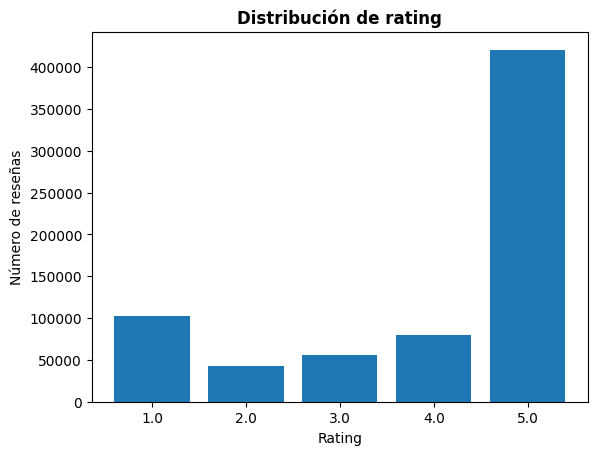


Proporción de reseñas positivas (rating >= 4): 0.713


In [9]:
# Distribución de rating:
rating_counts = eda_reviews["rating"].value_counts(dropna=False).sort_index()
print("Distribución de rating:")
print(rating_counts)

plt.figure()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title("Distribución de rating", weight="bold")
plt.xlabel("Rating")
plt.ylabel("Número de reseñas")
plt.show()

# Señal implícita ejemplo:
positive_rate = (eda_reviews["rating"] >= 4).mean()
print(f"\nProporción de reseñas positivas (rating >= 4): {positive_rate:.3f}")

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong> Conclusión </strong>: La distribución de <code>rating</code> está fuertemente concentrada en valores altos, especialmente en 5 estrellas, lo que indica un sesgo positivo típico en reseñas de e-commerce. Al convertir la señal a implícita con un umbral como <code>rating ≥ 4</code>, obtenemos una proporción alta de interacciones positivas (≈ 0.71), suficiente para construir un recomendador basado en co-ocurrencia. Esta observación respalda que el modelo Item-to-Item se alimente de eventos positivos, reduciendo el ruido de valoraciones bajas o ambiguas.
</div>


<br>
<h2>3.3. Dispersión: interacciones por usuario e ítem</h2>

<p>
En recomendación, la dispersión se observa claramente en la distribución de interacciones:
</p>

<ul>
  <li><b>Interacciones por usuario:</b> cuántos productos reseña cada usuario.</li>
  <li><b>Interacciones por ítem:</b> cuántas reseñas recibe cada <code>parent_asin</code>.</li>
</ul>

<p>
Si la mayoría de usuarios tiene 1–2 interacciones, los perfiles individuales son limitados y conviene priorizar estrategias
robustas basadas en patrones agregados (como Item-to-Item).
</p>

In [10]:
# Conteos:
user_counts = eda_reviews.groupby("user_id")["parent_asin"].size()
item_counts = eda_reviews.groupby("parent_asin")["user_id"].size()

def resumen_counts(s, nombre):
    desc = s.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
    print(f"\nResumen interacciones por {nombre}:")
    print(desc.to_string())
    print(f"% con 1 interacción: {(s == 1).mean():.3f}")
    print(f"% con <= 2 interacciones: {(s <= 2).mean():.3f}")
    print(f"% con <= 5 interacciones: {(s <= 5).mean():.3f}")

resumen_counts(user_counts, "usuario")
resumen_counts(item_counts, "ítem (parent_asin)")


Resumen interacciones por usuario:
count    631986.000000
mean          1.110037
std           0.753202
min           1.000000
50%           1.000000
75%           1.000000
90%           1.000000
95%           2.000000
99%           3.000000
max         165.000000
% con 1 interacción: 0.923
% con <= 2 interacciones: 0.986
% con <= 5 interacciones: 0.998

Resumen interacciones por ítem (parent_asin):
count    112565.000000
mean          6.232204
std          25.189840
min           1.000000
50%           2.000000
75%           4.000000
90%          11.000000
95%          21.000000
99%          73.000000
max        1962.000000
% con 1 interacción: 0.423
% con <= 2 interacciones: 0.599
% con <= 5 interacciones: 0.797


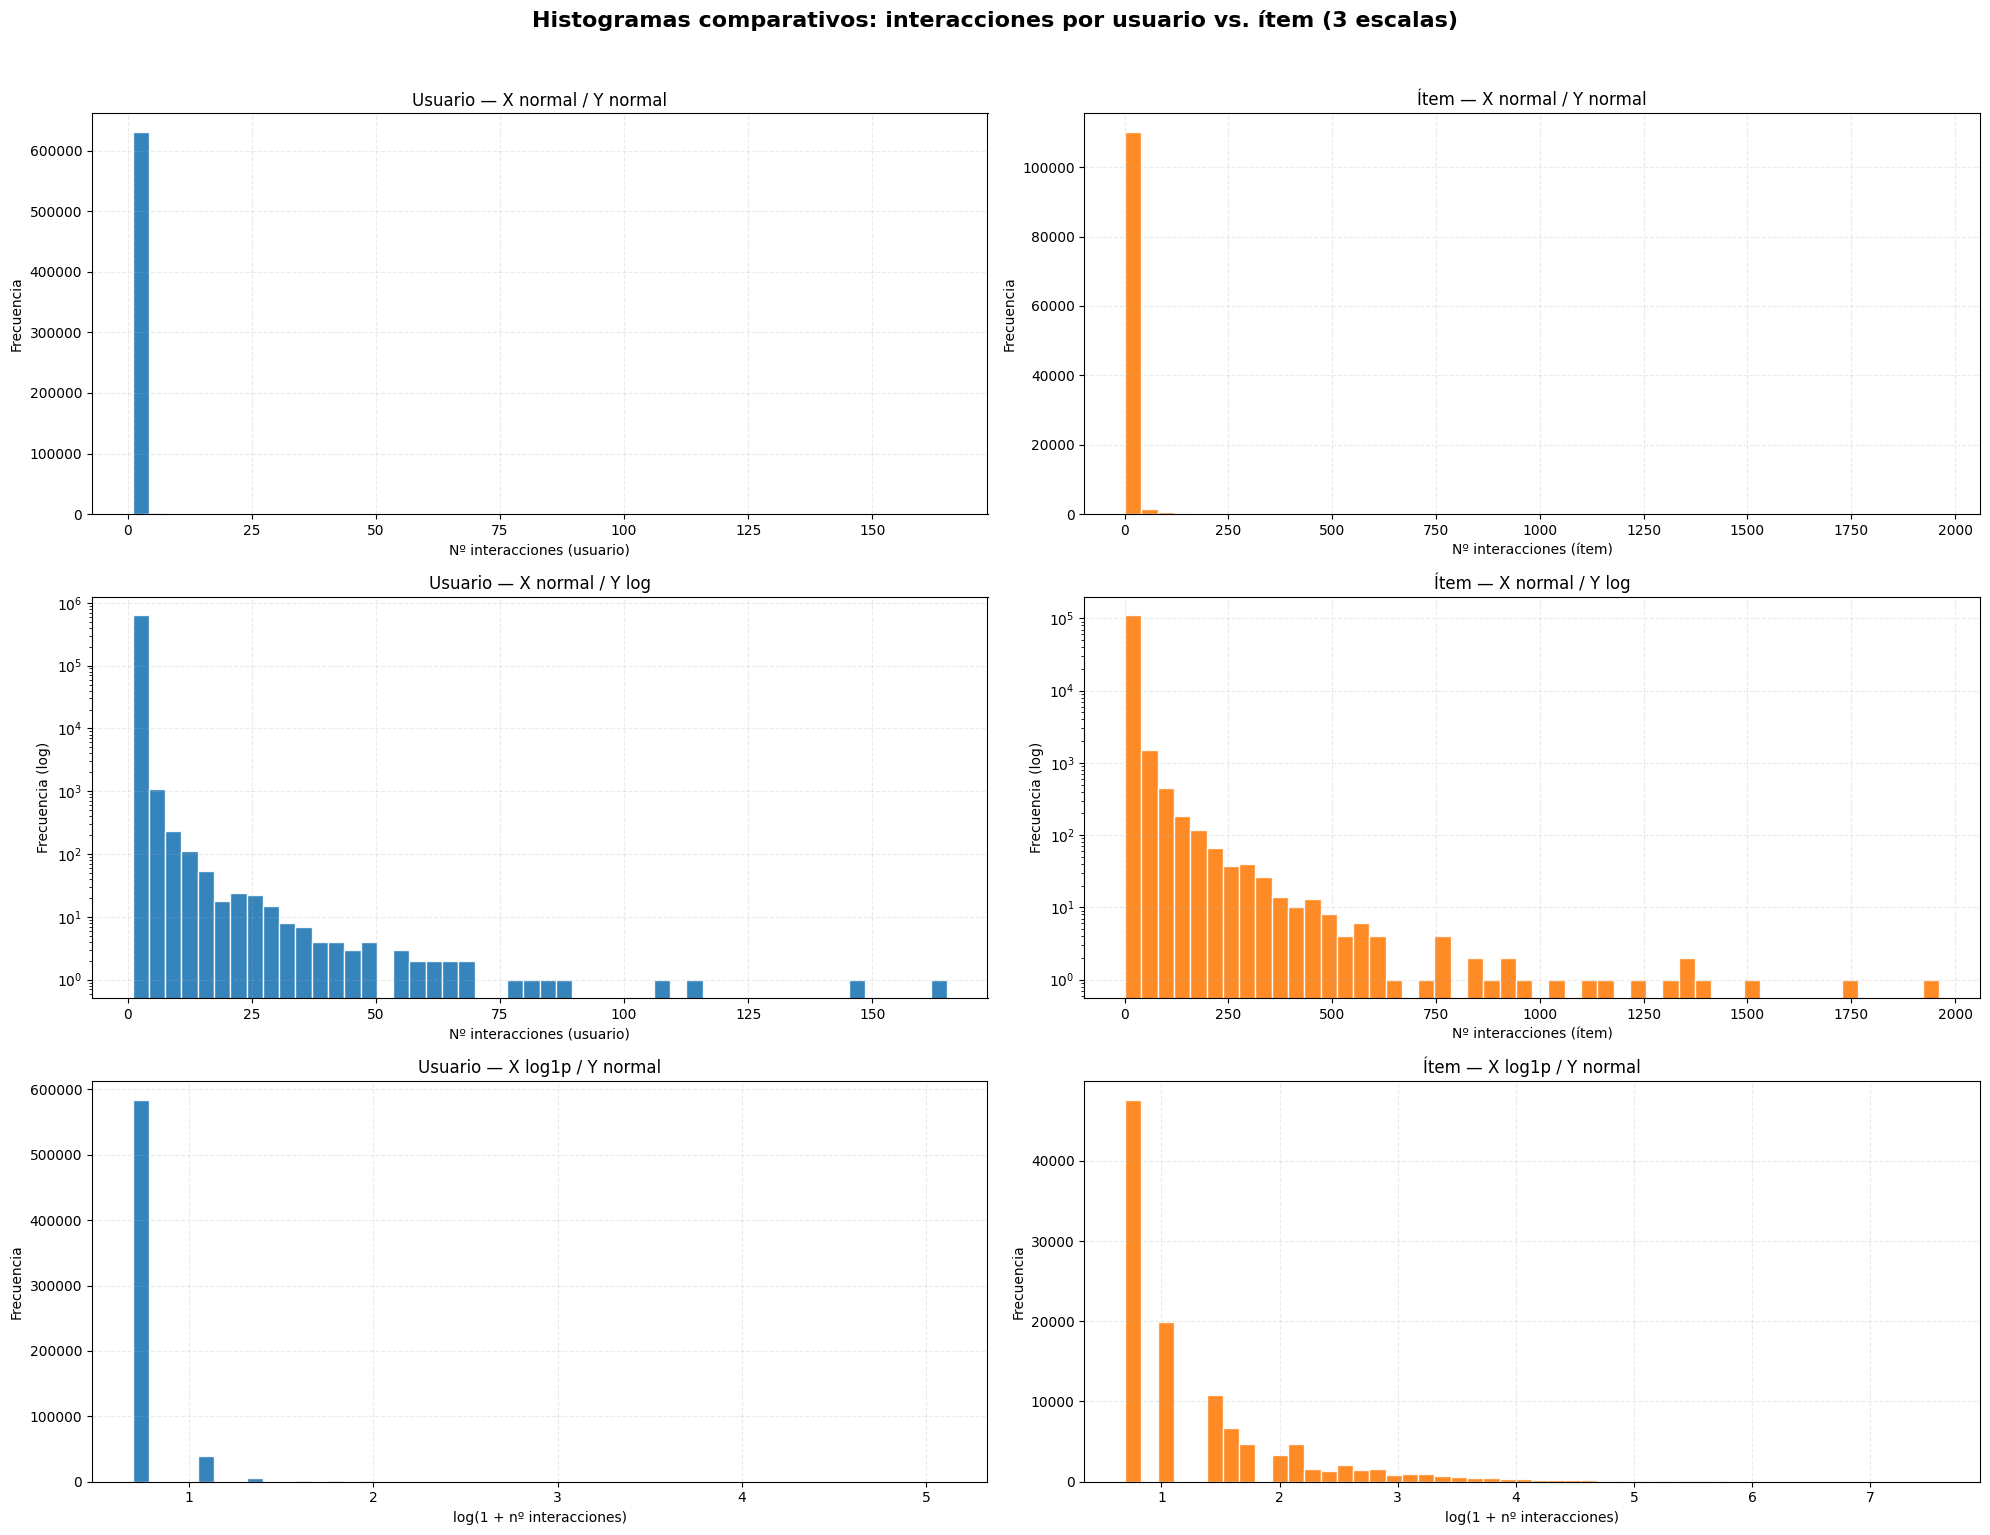

In [11]:
# Creamos los histogramas de interacciones por usuario vs ítems en 3 escalas diferentes para comparar:
# Conteos (si ya existen, puedes comentar estas dos líneas):
user_counts = df_reviews.groupby("user_id")["parent_asin"].size()
item_counts = df_reviews.groupby("parent_asin")["user_id"].size()

# Colores (usuario vs ítem):
color_user = "#1f77b4"  # azul
color_item = "#ff7f0e"  # naranja

fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# =========================
# Fila 1: X normal, Y normal:
# =========================
axes[0, 0].hist(user_counts, bins=50, color=color_user, alpha=0.9, edgecolor="white")
axes[0, 0].set_title("Usuario — X normal / Y normal")
axes[0, 0].set_xlabel("Nº interacciones (usuario)")
axes[0, 0].set_ylabel("Frecuencia")

axes[0, 1].hist(item_counts, bins=50, color=color_item, alpha=0.9, edgecolor="white")
axes[0, 1].set_title("Ítem — X normal / Y normal")
axes[0, 1].set_xlabel("Nº interacciones (ítem)")
axes[0, 1].set_ylabel("Frecuencia")

# =========================
# Fila 2: X normal, Y log:
# =========================
axes[1, 0].hist(user_counts, bins=50, color=color_user, alpha=0.9, edgecolor="white")
axes[1, 0].set_yscale("log")
axes[1, 0].set_title("Usuario — X normal / Y log")
axes[1, 0].set_xlabel("Nº interacciones (usuario)")
axes[1, 0].set_ylabel("Frecuencia (log)")

axes[1, 1].hist(item_counts, bins=50, color=color_item, alpha=0.9, edgecolor="white")
axes[1, 1].set_yscale("log")
axes[1, 1].set_title("Ítem — X normal / Y log")
axes[1, 1].set_xlabel("Nº interacciones (ítem)")
axes[1, 1].set_ylabel("Frecuencia (log)")

# =========================
# Fila 3: X log1p, Y normal:
# =========================
axes[2, 0].hist(np.log1p(user_counts), bins=50, color=color_user, alpha=0.9, edgecolor="white")
axes[2, 0].set_title("Usuario — X log1p / Y normal")
axes[2, 0].set_xlabel("log(1 + nº interacciones)")
axes[2, 0].set_ylabel("Frecuencia")

axes[2, 1].hist(np.log1p(item_counts), bins=50, color=color_item, alpha=0.9, edgecolor="white")
axes[2, 1].set_title("Ítem — X log1p / Y normal")
axes[2, 1].set_xlabel("log(1 + nº interacciones)")
axes[2, 1].set_ylabel("Frecuencia")

# Estética general:
for ax in axes.ravel():
    ax.grid(True, linestyle="--", alpha=0.25)

plt.suptitle("Histogramas comparativos: interacciones por usuario vs. ítem (3 escalas)", fontsize=16, y=1.02, weight="bold")
plt.tight_layout()
plt.show()

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong> Conclusión </strong>: El dataset es claramente disperso: la mayoría de usuarios registra muy pocas interacciones (mediana = 1) y una proporción muy alta tiene solo 1 reseña, lo que limita la construcción de perfiles individuales ricos. En cambio, a nivel de ítem existen productos con muchas más reseñas, lo que permite aprender relaciones producto–producto a partir de patrones agregados. Este patrón justifica priorizar un enfoque Item-to-Item, que no requiere historiales largos por usuario para generar recomendaciones.
</div>


<br>
<h2>3.4. Densidad (sparsity) y efecto long-tail</h2>

<p>
Calculamos la <b>densidad</b> aproximada de la matriz usuario–ítem:
</p>

<ul>
  <li><b>No ceros:</b> número de interacciones observadas (reseñas).</li>
  <li><b>Tamaño posible:</b> usuarios únicos × ítems únicos.</li>
  <li><b>Densidad:</b> no ceros / tamaño posible (cuanto menor, más dispersa).</li>
</ul>

<p>
Además, medimos el <b>long-tail</b> con una curva acumulada: qué porcentaje de interacciones se concentra en el top de ítems
más populares. Esto es relevante porque la popularidad puede sesgar el ranking si no la controlamos.
</p>

Densidad aproximada de la matriz usuario–ítem:
- Interacciones: 701.528
- Usuarios únicos: 631.986
- Ítems únicos: 112.565
- Densidad: 0.0000098613



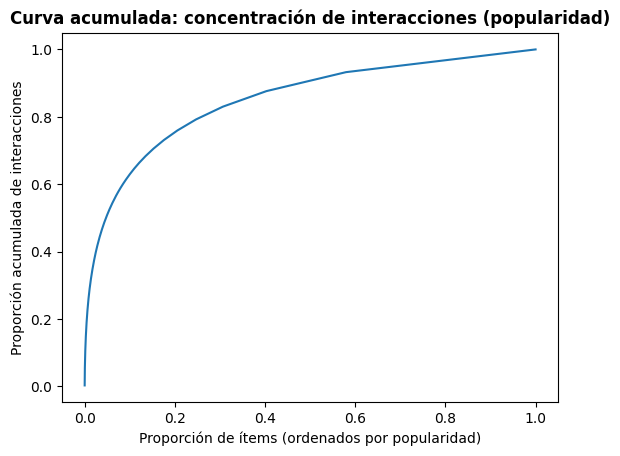


Interacciones cubiertas por el top 10% de ítems: 0.629
Interacciones cubiertas por el top 20% de ítems: 0.754


In [12]:
n_interactions = eda_reviews.shape[0]
n_users = eda_reviews["user_id"].nunique()
n_items = eda_reviews["parent_asin"].nunique()

density = n_interactions / (n_users * n_items)

print("Densidad aproximada de la matriz usuario–ítem:")
print(f"- Interacciones: {n_interactions:,}".replace(",", "."))
print(f"- Usuarios únicos: {n_users:,}".replace(",", "."))
print(f"- Ítems únicos: {n_items:,}".replace(",", "."))
print(f"- Densidad: {density:.10f}")
print("")

# Long-tail: proporción acumulada de interacciones por ítem ordenado por popularidad:
item_counts_sorted = item_counts.sort_values(ascending=False)
cum_share = item_counts_sorted.cumsum() / item_counts_sorted.sum()
x = np.arange(1, len(cum_share) + 1) / len(cum_share)  # % de ítems

plt.figure()
plt.plot(x, cum_share.values)
plt.title("Curva acumulada: concentración de interacciones (popularidad)",weight="bold")
plt.xlabel("Proporción de ítems (ordenados por popularidad)")
plt.ylabel("Proporción acumulada de interacciones")
plt.show()

# Puntos de referencia típicos (80/20 aproximado):
p20 = cum_share.iloc[int(0.2 * len(cum_share)) - 1]
p10 = cum_share.iloc[int(0.1 * len(cum_share)) - 1]
print(f"\nInteracciones cubiertas por el top 10% de ítems: {p10:.3f}")
print(f"Interacciones cubiertas por el top 20% de ítems: {p20:.3f}")


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong>Conclusión</strong>: La densidad estimada de la matriz usuario–ítem es extremadamente baja, confirmando un escenario típico de recomendación con alta esparsidad. Además, la curva acumulada muestra una fuerte concentración de interacciones en un subconjunto pequeño de ítems: el top 10% de productos acumula una fracción muy elevada de interacciones (≈ 0.63), evidenciando el efecto long-tail. Por tanto, es importante controlar la popularidad en el ranking final para evitar que el sistema recomiende de forma excesiva los ítems más frecuentes.
</div>


<br>
<h3>3.5. Evolución temporal de las interacciones</h3>

<p>
Analizamos la evolución temporal del número de reseñas para identificar cambios de actividad (crecimiento, caídas o periodos con distinta dinámica).
Este punto es útil para justificar (si procede) una evaluación con separación temporal y para entender si el comportamiento del dominio es estable.
</p>

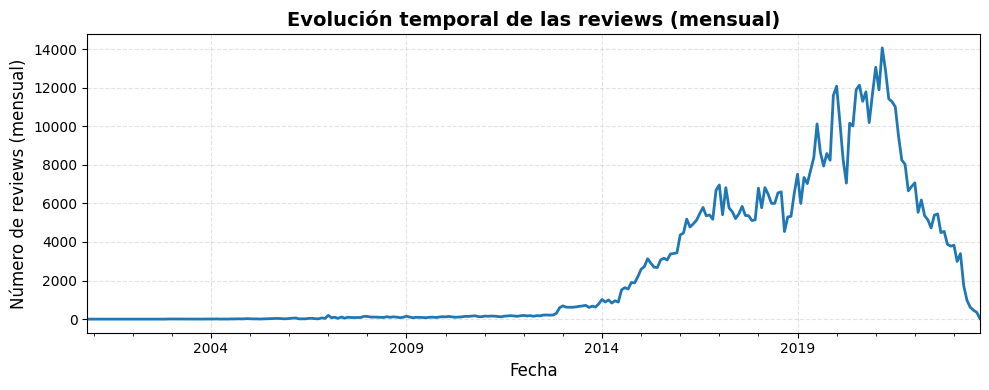

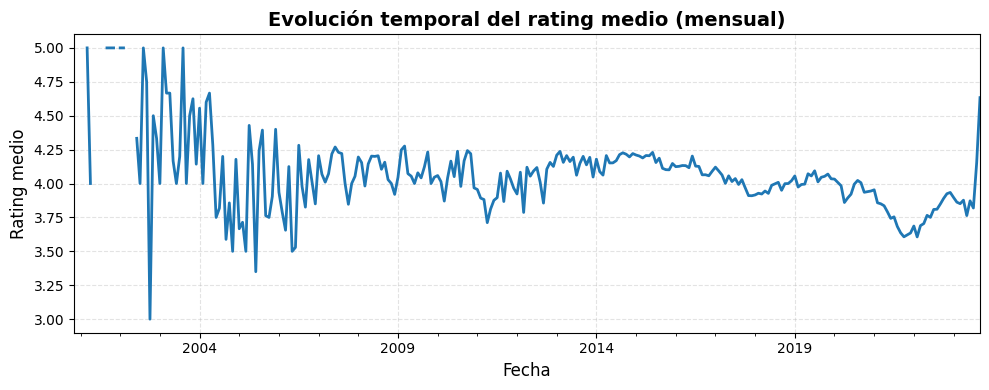

In [13]:
eda_reviews["fecha"] = pd.to_datetime(eda_reviews["timestamp"], unit="ms", errors="coerce")

interacciones_por_mes = eda_reviews.dropna(subset=["fecha"]).set_index("fecha").resample("ME")["user_id"].count()

plt.figure(figsize=(10, 4))
interacciones_por_mes.plot(linewidth=2)
plt.title("Evolución temporal de las reviews (mensual)", fontsize=14, weight="bold")
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de reviews (mensual)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

# (Opcional) rating medio mensual:
rating_medio_mes = eda_reviews.dropna(subset=["fecha"]).set_index("fecha").resample("ME")["rating"].mean()

plt.figure(figsize=(10, 4))
rating_medio_mes.plot(linewidth=2)
plt.title("Evolución temporal del rating medio (mensual)", fontsize=14, weight="bold")
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Rating medio", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <strong>Conclusión</strong>: La evolución mensual del número de reseñas muestra un crecimiento sostenido a partir de ~2014, un máximo alrededor de 2019–2021 y una caída marcada al final de la serie, lo que sugiere cambios de actividad (no estacionariedad) en el tiempo. En cambio, el <em>rating</em> medio mensual se mantiene relativamente estable (en torno a 4), por lo que la “calidad” media de la señal es consistente aunque el volumen de interacciones varíe. Por ello, tiene sentido plantear una evaluación con separación temporal para reflejar mejor un escenario realista.
</div>

<h3>3.6. Diagnóstico de <i>cold-start</i> (usuarios e ítems con poca evidencia)</h3>

<p>
Cuantificamos qué proporción de usuarios e ítems tiene muy pocas interacciones. Este indicador anticipa dónde el recomendador puede ser menos fiable:
</p>
<ul>
  <li><b>Usuarios nuevos</b>: historiales muy cortos (poca señal para personalización).</li>
  <li><b>Ítems nuevos</b>: pocos eventos (vecindarios item-to-item menos estables).</li>
</ul>

In [14]:
def cold_start_stats(s, nombre):
    stats = {
        "≤ 1": (s <= 1).mean(),
        "≤ 2": (s <= 2).mean(),
        "≤ 5": (s <= 5).mean(),
        "≤ 10": (s <= 10).mean()
    }
    print(f"\nCold-start — {nombre}:")
    for k, v in stats.items():
        print(f"- Proporción con {k} interacciones: {v:.3f}")

cold_start_stats(user_counts, "usuarios")
cold_start_stats(item_counts, "ítems")


Cold-start — usuarios:
- Proporción con ≤ 1 interacciones: 0.923
- Proporción con ≤ 2 interacciones: 0.986
- Proporción con ≤ 5 interacciones: 0.998
- Proporción con ≤ 10 interacciones: 1.000

Cold-start — ítems:
- Proporción con ≤ 1 interacciones: 0.423
- Proporción con ≤ 2 interacciones: 0.599
- Proporción con ≤ 5 interacciones: 0.797
- Proporción con ≤ 10 interacciones: 0.894


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <strong>Conclusión</strong>: El diagnóstico confirma un escenario de <em>cold-start</em> muy severo en usuarios: el 92,3% tiene ≤ 1 interacción y el 98,6% ≤ 2, por lo que para la mayoría no es posible construir perfiles individuales ricos. En ítems, la escasez de evidencia también es relevante (42,3% con ≤ 1 interacción y 59,9% con ≤ 2), lo que hace que la vecindad item-to-item sea menos fiable en la cola larga. En consecuencia, conviene priorizar estrategias que funcionen con historiales cortos y complementar el sistema con mecanismos de <em>fallback</em> para casos con poca evidencia.
</div>

<h3>3.7. Resumen ejecutivo del EDA</h3>

<p>
Recogemos en una tabla las métricas más relevantes del diagnóstico y su implicación directa sobre el diseño del recomendador.
</p>

In [15]:
summary = []

summary.append(("Interacciones (reviews)", n_interactions))
summary.append(("Usuarios únicos", n_users))
summary.append(("Ítems únicos (parent_asin)", n_items))
summary.append(("Densidad usuario–ítem", density))
summary.append(("Positivas (rating≥4)", positive_rate))
summary.append(("Top 10% ítems → share interacciones", float(p10)))
summary.append(("Top 20% ítems → share interacciones", float(p20)))

summary_df = pd.DataFrame(summary, columns=["Métrica", "Valor"])
summary_df

,Métrica,Valor
0,Interacciones (reviews),701528.000000
1,Usuarios únicos,631986.000000
2,Ítems únicos (parent_asin),112565.000000
3,Densidad usuario–ítem,0.000010
4,Positivas (rating≥4),0.712882
5,Top 10% ítems → share interacciones,0.629379
6,Top 20% ítems → share interacciones,0.754432


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <strong>Conclusión</strong>: Las métricas resumen consolidan el diagnóstico del dataset: alta esparsidad (densidad ≈ 0,000010), señal implícita viable (≈ 0,713 de reseñas positivas con <em>rating</em> ≥ 4) y fuerte concentración de popularidad (top 10% de ítems ≈ 0,629 de interacciones; top 20% ≈ 0,754). Este patrón justifica un enfoque colaborativo item-to-item basado en co-ocurrencias, pero también indica la necesidad de controlar el sesgo hacia productos muy populares en el ranking y de gestionar el <em>cold-start</em> en usuarios e ítems con poca evidencia.
</div>

<hr>
<br>
<h1>4. Preparación de datos y construcción de la señal (Item-to-Item)</h1>

<p>
En esta sección preparamos el dataset de interacciones para construir el recomendador <b>Item-to-Item</b>.
Partimos de <code>df_reviews</code> y definimos:
</p>

<ul>
  <li>la <b>unidad de ítem</b> (trabajaremos con <code>parent_asin</code>),</li>
  <li>la <b>señal de preferencia</b> (explícita vs. implícita),</li>
  <li>y reglas de limpieza para obtener un conjunto de interacciones consistente.</li>
</ul>

<p>
El resultado final de este apartado será un DataFrame de interacciones listo para construir una matriz dispersa usuario–ítem.
</p>

<br>

<h2>4.1. Selección de variables y limpieza básica</h2>

<p>
Nos quedamos con las columnas mínimas necesarias: <code>user_id</code>, <code>parent_asin</code>, <code>rating</code> y <code>timestamp</code>.
Eliminamos registros con valores nulos en campos clave y normalizamos tipos.
</p>


In [16]:
# 1) Selección mínima de variables:
cols_min = ["user_id", "parent_asin", "rating", "timestamp"]
cols_min = [c for c in cols_min if c in df_reviews.columns]  # por seguridad

df_inter = df_reviews[cols_min].copy()

# 2) Limpieza de nulos en campos clave:
df_inter = df_inter.dropna(subset=["user_id", "parent_asin", "rating"])

# 3) Tipos consistentes:
df_inter["user_id"] = df_inter["user_id"].astype(str)
df_inter["parent_asin"] = df_inter["parent_asin"].astype(str)
df_inter["rating"] = pd.to_numeric(df_inter["rating"], errors="coerce")

# timestamp puede tener nulos o formatos raros; lo normalizamos si existe:
if "timestamp" in df_inter.columns:
    df_inter["timestamp"] = pd.to_numeric(df_inter["timestamp"], errors="coerce")

# Eliminamos ratings no válidos tras coerción:
df_inter = df_inter.dropna(subset=["rating"])

print("Interacciones tras limpieza básica:", df_inter.shape)
df_inter.head()


Interacciones tras limpieza básica: (701528, 4)


,user_id,parent_asin,rating,timestamp
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,5.0,1588687728923
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,4.0,1588615855070
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,5.0,1589665266052
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1.0,1643393630220
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,5.0,1609322563534


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong>Conclusión</strong>: Se ha construido un dataset de interacciones con las variables mínimas (<code>user_id</code>, <code>parent_asin</code>, <code>rating</code> y <code>timestamp</code>), asegurando tipos consistentes y eliminando registros inválidos. Este preprocesado garantiza una base fiable para definir la señal de preferencia y construir posteriormente la matriz usuario–ítem sin ruido innecesario.
</div>


<br>

<h2>4.2. Definición de la señal (explícita vs. implícita)</h2>

<p>
Definimos dos versiones de la señal:
</p>

<ul>
  <li>
    <b>Explícita:</b> usamos <code>rating</code> (1–5) como intensidad de preferencia.
  </li>
  <li>
    <b>Implícita:</b> transformamos la valoración en un evento binario. Consideramos interacción positiva <code>rating ≥ 4</code> (valor 1)
    y el resto como 0.
  </li>
</ul>

<p>
Dado el sesgo hacia ratings altos y la alta esparsidad observada en el EDA, trabajaremos principalmente con la señal implícita,que es
más estable y adecuada para co-ocurrencias.
</p>

In [17]:
# Señal explícita (rating tal cual):
df_inter["signal_explicit"] = df_inter["rating"]

# Señal implícita (positivo si rating >= 4):
df_inter["signal_implicit"] = (df_inter["rating"] >= 4).astype(np.int8)

print(df_inter[["user_id", "parent_asin", "rating", "signal_explicit", "signal_implicit"]].head(10))

print("\nDistribución señal implícita:")
print(df_inter["signal_implicit"].value_counts(normalize=True))

                        user_id parent_asin  rating  signal_explicit  \
0  AGKHLEW2SOWHNMFQIJGBECAF7INQ  B00YQ6X8EO     5.0              5.0   
1  AGKHLEW2SOWHNMFQIJGBECAF7INQ  B081TJ8YS3     4.0              4.0   
2  AE74DYR3QUGVPZJ3P7RFWBGIX7XQ  B097R46CSY     5.0              5.0   
3  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  B09JS339BZ     1.0              1.0   
4  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ  B08BZ63GMJ     5.0              5.0   
5  AGMJ3EMDVL6OWBJF7CA5RGJLXN5A  B00R8DXL44     4.0              4.0   
6  AHREXOGQPZDA6354MHH4ETSF3MCQ  B099DRHW5V     5.0              5.0   
7  AEYORY2AVPMCPDV57CE337YU5LXA  B08BBQ29N5     3.0              3.0   
8  AFSKPY37N3C43SOI5IEXEK5JSIYA  B08P2DZB4X     5.0              5.0   
9  AFSKPY37N3C43SOI5IEXEK5JSIYA  B086QY6T7N     5.0              5.0   

   signal_implicit  
0                1  
1                1  
2                1  
3                0  
4                1  
5                1  
6                1  
7                0  
8                1

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong>Conclusión</strong>: Se han definido dos variantes de señal: una explícita (valoración 1–5) y una implícita binaria basada en umbral (<code>rating ≥ 4</code>). Dado el sesgo hacia ratings altos y la necesidad de estabilidad para co-ocurrencias, la señal implícita se adopta como principal, ya que reduce ruido y facilita el cálculo de similitud Item-to-Item.
</div>


<br>

<h2>4.3. Consolidación de duplicados usuario–ítem</h2>

<p>
Un mismo usuario puede escribir más de una reseña para el mismo <code>parent_asin</code> (por ejemplo, actualizaciones o compras repetidas).
Para construir una matriz usuario–ítem consistente, necesitamos una única interacción por par usuario–ítem.
</p>

<p>
Aplicamos una regla simple y reproducible: <b>nos quedamos con la interacción más reciente</b> (mayor <code>timestamp</code>).
En caso de no disponer de <code>timestamp</code> válido, se podría usar alternativamente el máximo <code>rating</code>.
</p>

In [18]:
# Si timestamp existe, usamos la interacción más reciente:
if "timestamp" in df_inter.columns:
    df_inter_sorted = df_inter.sort_values("timestamp")
    df_inter_1 = df_inter_sorted.drop_duplicates(subset=["user_id", "parent_asin"], keep="last")
else:
    # Alternativa si no hay timestamp: quedarnos con el rating máximo:
    df_inter_1 = (df_inter.sort_values("rating")
                         .drop_duplicates(subset=["user_id", "parent_asin"], keep="last"))

print("Antes de consolidar duplicados:", df_inter.shape)
print("Después de consolidar duplicados:", df_inter_1.shape)

# Comprobación rápida: ya no hay duplicados usuario–ítem:
dup_pairs = df_inter_1.duplicated(subset=["user_id", "parent_asin"]).sum()
print("Duplicados usuario–ítem restantes:", dup_pairs)

Antes de consolidar duplicados: (701528, 6)
Después de consolidar duplicados: (693929, 6)
Duplicados usuario–ítem restantes: 0


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong>Conclusión</strong>: Para asegurar una matriz usuario–ítem coherente, se han consolidado múltiples reseñas del mismo usuario sobre un mismo <code>parent_asin</code>, conservando únicamente la interacción más reciente (según <code>timestamp</code>). Con ello se elimina ambigüedad y se evita sobrerrepresentar pares usuario–ítem, estabilizando la señal para el cálculo posterior de similitudes.
</div>


<br>
<h3>4.4. Construcción de la matriz usuario–ítem (formato disperso CSR)</h3>

<p>
A partir del dataset consolidado <code>df_inter_1</code> (una única interacción por par usuario–ítem), construimos la matriz
<strong>usuario–ítem</strong> <em>R</em>, donde las filas representan usuarios, las columnas representan productos (<code>parent_asin</code>)
y los valores codifican la señal de interacción. Dado que el dataset es altamente disperso (EDA), utilizamos una representación
<strong>dispersa</strong> en formato <code>CSR</code> (<em>Compressed Sparse Row</em>), que permite almacenar únicamente los valores no nulos
y operar eficientemente (p. ej., cálculo de similitudes).
</p>

<p>
En este trabajo priorizamos la <strong>señal implícita</strong> (0/1) para capturar co-ocurrencias positivas de forma más estable.
No obstante, dejamos implementada también la construcción con <strong>señal explícita</strong> (rating) como variante comparable.
</p>


In [19]:
# Importamos la librería necesaria:
from scipy.sparse import csr_matrix

# =========================
# 1) Elección de señal:
# =========================
# Por defecto usamos la señal implícita:

signal_col = "signal_implicit"   # alternativa: "signal_explicit"

# Seguridad: comprobamos que existe la columna:
if signal_col not in df_inter_1.columns:
    raise ValueError(f"No existe la columna {signal_col} en df_inter_1. Revisa el apartado 4.2.")

# =========================
# 2) (Opcional) Filtrado mínimo para robustez:
# =========================
# Para estabilizar co-ocurrencias y reducir ruido, a veces se filtran:
# - ítems con muy pocas interacciones
# - usuarios con muy pocas interacciones
#
# En datasets muy dispersos, este paso es delicado: filtrar demasiado puede eliminar casi todo.
# Aquí lo dejamos "suave" y configurable.

MIN_USER_INTERACTIONS = 1   # También podemos probar con: 2
MIN_ITEM_INTERACTIONS = 1   # También podemos probar con: 2 o 3

tmp = df_inter_1.copy()

# Conteos por usuario e ítem:
user_freq = tmp.groupby("user_id")["parent_asin"].size()
item_freq = tmp.groupby("parent_asin")["user_id"].size()

valid_users = user_freq[user_freq >= MIN_USER_INTERACTIONS].index
valid_items = item_freq[item_freq >= MIN_ITEM_INTERACTIONS].index

tmp = tmp[tmp["user_id"].isin(valid_users) & tmp["parent_asin"].isin(valid_items)].copy()

print("Interacciones tras filtrado mínimo:", tmp.shape)

# =========================
# 3) Indexado (ID -> índice):
# =========================
# CSR requiere índices enteros consecutivos para filas y columnas.

user_ids = tmp["user_id"].astype(str).unique()
item_ids = tmp["parent_asin"].astype(str).unique()

user_to_idx = {u: i for i, u in enumerate(user_ids)}
item_to_idx = {it: j for j, it in enumerate(item_ids)}

tmp["user_idx"] = tmp["user_id"].map(user_to_idx)
tmp["item_idx"] = tmp["parent_asin"].map(item_to_idx)

n_users = len(user_ids)
n_items = len(item_ids)

# =========================
# 4) Construcción CSR:
# =========================
# data: valores no nulos (señal)
# rows: índices de usuario
# cols: índices de ítem

data = tmp[signal_col].astype(np.float32).values
rows = tmp["user_idx"].astype(np.int32).values
cols = tmp["item_idx"].astype(np.int32).values

R = csr_matrix((data, (rows, cols)), shape=(n_users, n_items))

print("Matriz CSR construida:")
print(" - shape:", R.shape)
print(" - nnz (no ceros):", R.nnz)
print(" - densidad aproximada:", R.nnz / (R.shape[0] * R.shape[1]))

# Guardamos objetos útiles para los siguientes pasos:
df_inter_matrix = tmp

Interacciones tras filtrado mínimo: (693929, 6)
Matriz CSR construida:
 - shape: (631986, 112565)
 - nnz (no ceros): 693929
 - densidad aproximada: 9.754481829422042e-06


In [20]:
# Comprobaciones rápidas para validar la matriz.
# 1) No hay índices fuera de rango:
assert df_inter_matrix["user_idx"].max() < R.shape[0]
assert df_inter_matrix["item_idx"].max() < R.shape[1]

# 2) Para señal implícita, los valores deben ser 0/1 y en CSR solo se guardan los 1 (lo normal):
if signal_col == "signal_implicit":
    unique_vals = set(np.unique(df_inter_matrix[signal_col].values))
    print("Valores únicos en signal_implicit:", unique_vals)

# 3) Ejemplo: número de interacciones del primer usuario en la matriz:
u0 = 0
print("Interacciones del usuario 0 (nnz en fila 0):", R[u0].nnz)

Valores únicos en signal_implicit: {np.int8(0), np.int8(1)}
Interacciones del usuario 0 (nnz en fila 0): 1


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong>Conclusión</strong>: A partir del dataset ya consolidado (una única interacción por par usuario–ítem), se ha construido correctamente la matriz usuario–ítem en formato disperso <em>CSR</em>, adecuada para un escenario de alta esparsidad. La matriz resultante tiene dimensión <b>631.986 × 112.565</b> y <b>693.929</b> valores no nulos (<em>nnz</em>), lo que implica una densidad aproximada de <b>9,75·10⁻⁶</b> (extremadamente baja), coherente con el diagnóstico del EDA. Además, la validación confirma que la señal implícita queda codificada como <b>{0,1}</b> y que no hay índices fuera de rango; por tanto, esta representación es consistente y eficiente para calcular similitudes ítem–ítem en los siguientes pasos.
</div>

<br>
<h3>4.5. Cálculo de similitud ítem–ítem</h3>

<p>
A partir de la matriz usuario–ítem <b>R</b> (CSR), calculamos una medida de similitud entre productos para construir el vecindario
<b>Item-to-Item</b>. En este trabajo usamos <b>similitud del coseno</b>, que compara el patrón de co-ocurrencias de dos ítems en los historiales
de los usuarios y es especialmente adecuada en matrices dispersas.
</p>

<p>
Dado el tamaño del catálogo, no construimos una matriz densa ítem–ítem completa (coste O(n<sub>ítems</sub><sup>2</sup>)), sino que calculamos
los <b>Top-K vecinos</b> por ítem (vecindarios esparsos). Este diseño reduce memoria y acelera la recomendación posterior.
</p>

In [21]:
# Importamos las librerías necesarias:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# =========================
# 1) Definimos parámetros:
# =========================
TOPK = 50  # vecinos por ítem (lo podemos ajustar a: 20, 50, 100)
MIN_NNZ_ITEM = 2  # opcional: ítems con 1 sola interacción generan vecinos poco fiables

# =========================
# 2) Pre-checks y preparación:
# =========================
# Para similitud ítem–ítem comparamos columnas -> trabajamos con la traspuesta (ítems x usuarios):
R_item_user = R.T.tocsr()  # shape: (n_items, n_users)

# Filtrado opcional: evitamos ítems demasiado raros (vecindario inestable):
item_nnz = np.diff(R_item_user.indptr)  # nnz por fila (ítem) en R_item_user

valid_items_mask = item_nnz >= MIN_NNZ_ITEM
valid_item_idx = np.where(valid_items_mask)[0]

print("Items totales:", R_item_user.shape[0])
print("Items con nnz >=", MIN_NNZ_ITEM, ":", len(valid_item_idx))

# Comentamos opcionalmente esto:
R_item_user_f = R_item_user[valid_item_idx]

# =========================
# 3) Similitud coseno (sparse-friendly):
# =========================
# cosine_similarity sobre CSR devuelve matriz densa si la pedimos completa.
# Estrategia: calcular por bloques y quedarnos con Top-K por fila (vecindario esparso).
def topk_neighbors_by_blocks(X_csr: csr_matrix, topk: int = 50, block_size: int = 2000):
    """
    Calcula Top-K vecinos por ítem para X (items x users) usando similitud coseno por bloques.
    Devuelve:
      - neigh_idx: (n_items, topk) índices de vecinos
      - neigh_sim: (n_items, topk) similitudes correspondientes
    """
    n_items = X_csr.shape[0]
    neigh_idx = np.zeros((n_items, topk), dtype=np.int32)
    neigh_sim = np.zeros((n_items, topk), dtype=np.float32)

    for start in range(0, n_items, block_size):
        end = min(start + block_size, n_items)
        X_block = X_csr[start:end]

        # similitud coseno bloque vs todos (denso: (block, n_items)):
        S = cosine_similarity(X_block, X_csr, dense_output=True)

        # quitamos auto-similitud para evitar recomendarse a sí mismo:
        for i in range(end - start):
            S[i, start + i] = -1.0

        # Top-K por fila (más eficiente que sort completo):
        idx_part = np.argpartition(-S, kth=topk-1, axis=1)[:, :topk]
        sim_part = np.take_along_axis(S, idx_part, axis=1)

        # ordenamos esos Top-K de mayor a menor:
        order = np.argsort(-sim_part, axis=1)
        idx_sorted = np.take_along_axis(idx_part, order, axis=1)
        sim_sorted = np.take_along_axis(sim_part, order, axis=1)

        neigh_idx[start:end] = idx_sorted.astype(np.int32)
        neigh_sim[start:end] = sim_sorted.astype(np.float32)

        print(f"Bloque {start}:{end} procesado")

    return neigh_idx, neigh_sim

neigh_idx_f, neigh_sim_f = topk_neighbors_by_blocks(R_item_user_f, topk=TOPK, block_size=1500)

print("Vecindarios calculados (filtrados):")
print(" - neigh_idx_f shape:", neigh_idx_f.shape)
print(" - neigh_sim_f shape:", neigh_sim_f.shape)

# =========================
# 4) Re-mapeo a índices originales (si filtramos):
# =========================
# neigh_idx_f está en el espacio "filtrado" (0..len(valid_item_idx)-1)
# Convertimos a índices reales del catálogo:
valid_to_real = valid_item_idx  # map fila_filtrada -> item_real

neigh_idx_real = valid_to_real[neigh_idx_f]  # shape: (n_valid_items, TOPK)
item_real_ids = valid_to_real                 # item_real_ids[i] es el ítem real de la fila i del filtrado

print("Ejemplo (primer ítem filtrado):")
print("Ítem real:", item_real_ids[0])
print("Vecinos reales:", neigh_idx_real[0][:10])
print("Similitudes:", neigh_sim_f[0][:10])

# Guardamos para el paso 5 (recomendación):
neighbors = {
    "item_real_ids": item_real_ids,      # (n_valid_items,)
    "neigh_idx": neigh_idx_real,         # (n_valid_items, TOPK) vecinos en índice real
    "neigh_sim": neigh_sim_f,            # (n_valid_items, TOPK) similitud
    "topk": TOPK,
    "min_nnz_item": MIN_NNZ_ITEM
}


Items totales: 112565
Items con nnz >= 2 : 64618
Bloque 0:1500 procesado
Bloque 1500:3000 procesado
Bloque 3000:4500 procesado
Bloque 4500:6000 procesado
Bloque 6000:7500 procesado
Bloque 7500:9000 procesado
Bloque 9000:10500 procesado
Bloque 10500:12000 procesado
Bloque 12000:13500 procesado
Bloque 13500:15000 procesado
Bloque 15000:16500 procesado
Bloque 16500:18000 procesado
Bloque 18000:19500 procesado
Bloque 19500:21000 procesado
Bloque 21000:22500 procesado
Bloque 22500:24000 procesado
Bloque 24000:25500 procesado
Bloque 25500:27000 procesado
Bloque 27000:28500 procesado
Bloque 28500:30000 procesado
Bloque 30000:31500 procesado
Bloque 31500:33000 procesado
Bloque 33000:34500 procesado
Bloque 34500:36000 procesado
Bloque 36000:37500 procesado
Bloque 37500:39000 procesado
Bloque 39000:40500 procesado
Bloque 40500:42000 procesado
Bloque 42000:43500 procesado
Bloque 43500:45000 procesado
Bloque 45000:46500 procesado
Bloque 46500:48000 procesado
Bloque 48000:49500 procesado
Bloque 495

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Conclusión:</b> A partir de la matriz usuario–ítem en formato disperso (CSR), se ha construido correctamente el vecindario <i>Item-to-Item</i> utilizando la similitud del coseno, una métrica especialmente adecuada para capturar patrones de co-ocurrencia en escenarios de alta esparsidad.
  <br><br>
  Para garantizar la viabilidad computacional, el cálculo se ha realizado por bloques y limitando el vecindario a los <i>Top-K</i> vecinos por ítem, evitando la construcción explícita de una matriz ítem–ítem densa de coste cuadrático. Adicionalmente, se ha aplicado un filtrado mínimo de ítems con baja evidencia (muy pocas interacciones), reduciendo la generación de similitudes poco fiables.
  <br><br>
  En conjunto, el resultado es un vecindario disperso, escalable y consistente, que permite identificar relaciones relevantes entre productos y constituye la base del motor de recomendación <i>Item-to-Item</i> empleado en los siguientes pasos del sistema.
</div>

<br>
<h3>4.6. Cobertura de productos</h3>

<p>
Dado que el vecindario <i>Item-to-Item</i> se construye únicamente para ítems con soporte mínimo
(<code>MIN_NNZ_ITEM</code>), no todos los productos del catálogo quedan representados en el modelo.
Por ello, reportamos la <b>cobertura de productos</b>, entendida como el porcentaje de ítems que
(a) cumplen el umbral de evidencia y (b) pueden participar en el vecindario (por tanto, ser recomendados mediante co-ocurrencia).
</p>

<p>
En concreto, medimos:
(i) <b>cobertura del catálogo</b> = nº ítems válidos / nº ítems totales,
(ii) <b>cobertura sobre ítems con interacción positiva</b> = nº ítems con señal positiva que aparecen en el vecindario / nº ítems con señal positiva,
y (iii) <b>retención de interacciones positivas</b> = nº interacciones positivas asociadas a ítems válidos / nº interacciones positivas totales.
Estas magnitudes contextualizan el impacto del filtrado y anticipan el <i>cold-start</i> de ítems raros.
</p>

In [22]:
from scipy.sparse import csr_matrix

# =========================
# Cobertura de productos:
# =========================

# -------------------------
# 0) Pre-checks (robustos):
# -------------------------
# Si R fue "pisada" y ya no es CSR, intentamos recuperarla desde R_item_user si existe.
if not isinstance(R, csr_matrix):
    if "R_item_user" in globals() and isinstance(R_item_user, csr_matrix):
        R = R_item_user.T.tocsr()
        print("⚠️ R no era CSR. Restaurada desde R_item_user.T")
    else:
        raise TypeError(
            f"R no es csr_matrix (es {type(R)}). "
            "Re-ejecuta el apartado 4.4 (construcción de R) o recupera R desde R_item_user."
        )

n_users, n_items_total = R.shape
print("R.shape (n_users, n_items):", R.shape)

# neighbors["item_real_ids"] deberían ser ítems en el espacio real (0..n_items_total-1):
items_in_neighbors = np.asarray(neighbors["item_real_ids"]).astype(int)
items_in_neighbors_set = set(items_in_neighbors.tolist())
n_items_neighbors = len(items_in_neighbors_set)

# Comprobación de rangos (si falla, el 4.5 NO está remapeando a "real"):
if n_items_neighbors > 0:
    mx = max(items_in_neighbors_set)
    mn = min(items_in_neighbors_set)
    print("Rango item_idx en neighbors:", (mn, mx))
    assert mx < n_items_total, (
        f"Índices fuera de rango en neighbors: max={mx}, pero n_items_total={n_items_total}. "
        "Esto indica que neighbors['item_real_ids'] NO está en el espacio de índices de R. "
        "Revisa el re-mapeo del 4.5 (valid_to_real = valid_item_idx; item_real_ids = valid_to_real)."
    )

# -------------------------
# 1) Soporte por item (nnz) y válidos:
# -------------------------
# nnz por ítem = nº usuarios con interacción:
R_item_user_full = R.T.tocsr()  # (n_items, n_users)
item_support = np.diff(R_item_user_full.indptr)

MIN_NNZ_ITEM = int(neighbors.get("min_nnz_item", 2))
valid_item_idx = np.where(item_support >= MIN_NNZ_ITEM)[0]
n_items_valid = int(valid_item_idx.size)

coverage_catalog = n_items_valid / n_items_total if n_items_total else 0.0

# -------------------------
# 2) Cobertura sobre ítems con interacción positiva (signal_implicit=1):
# -------------------------
# Asumimos df_inter_matrix con columna item_idx en el mismo espacio de índices que R (0..n_items-1):
pos = df_inter_matrix[df_inter_matrix["signal_implicit"] == 1].copy()
items_pos = set(pos["item_idx"].astype(int).unique().tolist())
n_items_pos = len(items_pos)

n_items_pos_covered = len(items_pos.intersection(items_in_neighbors_set))
coverage_pos_items = n_items_pos_covered / n_items_pos if n_items_pos else 0.0

# -------------------------
# 3) Retención de interacciones positivas:
# -------------------------
n_pos_interactions_total = int(pos.shape[0])
n_pos_interactions_kept = int(pos[pos["item_idx"].astype(int).isin(items_in_neighbors_set)].shape[0])
retention_pos_interactions = (
    n_pos_interactions_kept / n_pos_interactions_total if n_pos_interactions_total else 0.0
)

# -------------------------
# 4) Reporte numérico:
# -------------------------
print("\n=== Cobertura de productos (vecindario) ===")
print(f"Ítems totales (catálogo):                  {n_items_total}")
print(f"Ítems válidos (nnz >= {MIN_NNZ_ITEM}):             {n_items_valid}")
print(f"Ítems cubiertos por vecindario (neighbors): {n_items_neighbors}")
print(f"Cobertura del catálogo:                    {coverage_catalog:.4f} ({coverage_catalog*100:.2f}%)")

print("\n=== Cobertura sobre señal positiva ===")
print(f"Ítems con señal positiva (unique):         {n_items_pos}")
print(f"Ítems positivos cubiertos por vecind.:     {n_items_pos_covered}")
print(f"Cobertura en ítems positivos:              {coverage_pos_items:.4f} ({coverage_pos_items*100:.2f}%)")

print("\n=== Retención de interacciones positivas ===")
print(f"Interacciones positivas totales:           {n_pos_interactions_total}")
print(f"Interacciones positivas en ítems cubiertos:{n_pos_interactions_kept}")
print(f"Retención (positivas):                     {retention_pos_interactions:.4f} ({retention_pos_interactions*100:.2f}%)")

# -------------------------
# 5) “Qué productos cubre” (título + descripción) SIN hacerlo lento:
#    -> join SOLO para lo que vamos a mostrar
# -------------------------
item_ids_arr = np.asarray(item_ids)
assert item_ids_arr.size == n_items_total, (
    f"len(item_ids)={item_ids_arr.size} pero n_items_total={n_items_total}. "
    "Revisa el 4.4: item_ids debe alinearse con item_to_idx (mismo orden)."
)

covered_idx = np.array(sorted(items_in_neighbors_set), dtype=int)
not_covered_idx = np.setdiff1d(np.arange(n_items_total, dtype=int), covered_idx)

df_cov = pd.DataFrame({
    "item_idx": covered_idx,
    "parent_asin": item_ids_arr[covered_idx],
    "support_nnz": item_support[covered_idx]
}).sort_values("support_nnz", ascending=False)

df_ncov = pd.DataFrame({
    "item_idx": not_covered_idx,
    "parent_asin": item_ids_arr[not_covered_idx],
    "support_nnz": item_support[not_covered_idx]
}).sort_values("support_nnz", ascending=False)

# -------------------------
# Helpers (robustos):
# -------------------------
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def clean_text(x):
    # Maneja None / NaN sin romper con arrays
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""

    # numpy array
    if isinstance(x, np.ndarray):
        if x.size == 0:
            return ""
        return " ".join([str(t) for t in x.flatten().tolist() if t is not None]).strip()

    # lista
    if isinstance(x, list):
        return " ".join([str(t) for t in x if t is not None]).strip()

    # dict
    if isinstance(x, dict):
        return " ".join([str(v) for v in x.values() if v is not None]).strip()

    s = str(x).strip()
    return "" if s.lower() in {"nan", "none"} else s

MAX_LEN = 250
def clip(s, n=MAX_LEN):
    s = "" if s is None else str(s)
    return s if len(s) <= n else s[:n] + "..."

# Columnas típicas en meta:
asin_col  = pick_col(df_meta, ["parent_asin", "asin", "item_id"])
title_col = pick_col(df_meta, ["title", "product_title", "name"])
desc_col  = pick_col(df_meta, ["description", "product_description", "features"])

def attach_meta(df_small: pd.DataFrame) -> pd.DataFrame:
    # si no hay asin_col, devolvemos tal cual
    if asin_col is None:
        return df_small

    cols = [asin_col]
    if title_col is not None: cols.append(title_col)
    if desc_col is not None: cols.append(desc_col)

    meta_small = df_meta[cols].copy().rename(columns={asin_col: "parent_asin"})
    out = df_small.merge(meta_small, on="parent_asin", how="left")

    if title_col is not None and title_col in out.columns:
        out[title_col] = out[title_col].map(clean_text)

    if desc_col is not None and desc_col in out.columns:
        out[desc_col] = out[desc_col].map(clean_text).map(clip)

    return out

# Qué mostramos (para no hacerlo pesado):
TOP_N = 20
SAMPLE_N = 20

df_cov_top  = attach_meta(df_cov.head(TOP_N))
df_ncov_top = attach_meta(df_ncov.head(TOP_N))

df_cov_s  = attach_meta(df_cov.sample(min(SAMPLE_N, len(df_cov)), random_state=42))
df_ncov_s = attach_meta(df_ncov.sample(min(SAMPLE_N, len(df_ncov)), random_state=42))

print("\n=== Productos CUBIERTOS (Top por soporte) ===")
display(df_cov_top)

print("\n=== Productos NO CUBIERTOS (Top por soporte) ===")
display(df_ncov_top)

print("\n=== Productos CUBIERTOS (muestra aleatoria) ===")
display(df_cov_s)

print("\n=== Productos NO CUBIERTOS (muestra aleatoria) ===")
display(df_ncov_s)

# -------------------------
# 6) Resumen estadístico soporte cubiertos vs no cubiertos:
# -------------------------
def summarize(arr):
    arr = np.asarray(arr)
    return {
        "count": int(arr.size),
        "min": int(arr.min()) if arr.size else None,
        "p50": float(np.percentile(arr, 50)) if arr.size else None,
        "p90": float(np.percentile(arr, 90)) if arr.size else None,
        "p95": float(np.percentile(arr, 95)) if arr.size else None,
        "max": int(arr.max()) if arr.size else None,
        "mean": float(arr.mean()) if arr.size else None,
    }

summary = pd.DataFrame({
    "group": ["covered", "not_covered"],
    "stats": [summarize(item_support[covered_idx]), summarize(item_support[not_covered_idx])]
})

print("\n=== Soporte (nnz) en productos cubiertos vs no cubiertos ===")
display(summary)


R.shape (n_users, n_items): (631986, 112565)
Rango item_idx en neighbors: (0, 112548)

=== Cobertura de productos (vecindario) ===
Ítems totales (catálogo):                  112565
Ítems válidos (nnz >= 2):             64618
Ítems cubiertos por vecindario (neighbors): 64618
Cobertura del catálogo:                    0.5741 (57.41%)

=== Cobertura sobre señal positiva ===
Ítems con señal positiva (unique):         91185
Ítems positivos cubiertos por vecind.:     60522
Cobertura en ítems positivos:              0.6637 (66.37%)

=== Retención de interacciones positivas ===
Interacciones positivas totales:           494769
Interacciones positivas en ítems cubiertos:464106
Retención (positivas):                     0.9380 (93.80%)

=== Productos CUBIERTOS (Top por soporte) ===


,item_idx,parent_asin,support_nnz,title,description
0,1941,B085BB7B1M,1952,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,The product has been given as the following : ...
1,7251,B0BM4GX6TT,1726,"Godefroy Tint Kit for Spot Coloring, Dark Brown",Godefroy Professional Hair Color Tint Kit is i...
2,37478,B07C533XCW,1500,Segbeauty empty bottle 160083,
3,26581,B09X9BG4FC,1364,Makone Crystal Crowns and Tiaras with Comb Hea...,
4,7621,B00R1TAN7I,1362,GranNaturals Boar Bristle Smoothing Hair Brush...,
5,77243,B08L5KN7X4,1328,Meeteasy Dental Cleaner Tool Kit - Dental Care...,
6,12598,B019GBG0IE,1319,Collapsible Hair Diffuser by The Curly Co. wit...,Whether you're trying to fit yet another styli...
7,2222,B01M1OFZOG,1234,Bed Head Curve Check Curling Wand for Tousled ...,TOUSLED WAVES AND TEMPTING TEXTURE. Give your ...
8,39210,B0C9CWKY9G,1133,Picoway 20 Pack Mouse Ears Solid Black and Red...,WHAT YOU GET: We will s erve you 30-DAY MONEY-...
9,9981,B0107QYW14,1105,Harlorki Women's Bohemian Jewelry Statement Ne...,



=== Productos NO CUBIERTOS (Top por soporte) ===


,item_idx,parent_asin,support_nnz,title,description
0,112564,B0B38YRJKY,1,Hot Air Brush Hair Dryer Hot Air Brush One Ste...,Specification: Condition: 100% Brand New Item ...
1,4,B000050B65,1,Norelco 6885XL Deluxe Quadra Action Cord/Cordl...,Product Description This high-tech shaver come...
2,34,B00015JO60,1,Pré de Provence - Green Tea 150 gr,
3,37,B0000532E2,1,"The Gillette Series Shave Gel, Deep Clean, 7-O...",Formulated with Tea Tree Oil to penetrate and ...
4,38,B0001ZI0BU,1,Crest Whitestrips Premium - Dental Whitening S...,Crest Whitestrips whitening power comes from a...
5,39,B00030BCVI,1,BETA-androsteNOL,Reagent grade BETA-androsteNOL pheromone. It c...
6,41,B00023IXLS,1,Curve Cologne by Liz Claiborne for men Colognes,
7,42,B0002LF2HI,1,Shunga Geisha's Secrets Collection,SHUNGA GEISHA SECRETS COLLECTION es un complet...
8,51,B00064A816,1,"Zia Natural Skincare Ultimate Body Butter, 6 oz",Discover why our customers cannot get enought ...
9,53,B00009RB12,1,Norelco Mens Electric Razor - 7845XL,Product Description Norelco's Quadra Action Sh...



=== Productos CUBIERTOS (muestra aleatoria) ===


,item_idx,parent_asin,support_nnz,title,description
0,34643,B076C98GWR,2,Brazilian Virgin Hair Deep Wave 3 bundles With...,
1,80358,B08P721861,2,DARANA Clip in Bang 100% Real Human Hair Exten...,
2,67375,B0763TRN3T,2,Hair One Cleanser and Conditioner with Olive O...,Hair One Hair Cleanser Conditioner is a salon ...
3,92430,B09321HSCC,3,"Heatless Hair Curlers Rollers, No Heat Silk Cu...",
4,48255,B07PQHSKYY,3,"KEBEIER Mini Electric Epilator, Women's AAA Ba...",That is the easy and affordable hair remover t...
5,41796,B071X938JJ,13,Jiaying-US 5 Pairs Silicone Eyeglasses Replace...,Pack of 5 pairs Color:Black Silicone eyeglass ...
6,29293,B074HFPGVN,18,"6-bottle Essential Oil Carrying Case (5ml,10ml...",Transport your essential oils in style with th...
7,56950,B07VVQHJSV,3,Ombre Blonde Lace Front Wig Wavy with Brown Ro...,
8,12891,B00YZ5ZMEK,4,Nickelodeon PAW PATROL 48 Piece Party Favor Pa...,PAW Patrol Favor Pack include: 8 Dog tag keych...
9,42156,B076QY8N23,2,Avon Anew Skinvincible Deep Recovery Cream lot...,



=== Productos NO CUBIERTOS (muestra aleatoria) ===


,item_idx,parent_asin,support_nnz,title,description
0,110664,B013L10JN2,1,Chris Christensen Groomers Bundle - Big G Slic...,
1,108466,B07TJW3CLN,1,Ani·Lnc Trish Una Cosplay Wig Short Pink Cospl...,Product Details -- Material:100% Japanese KANE...
2,39555,B07F5JNT4C,1,Shampoo Bar Natural Plant Essential Oil Soap B...,
3,10639,B00V908ZH0,1,Baby Magic Diaper Rx Max- Strength 3 Ounce (88...,"Helps Prevent Diaper Rash, With 40% Zinc Oxide..."
4,108215,B09XQTZD36,1,2Pcs Long Corn Wave Ponytail Extension 24 Inch...,
5,20664,B01N9AVGTU,1,Kanebo Japan Evita Beauty Whip SOAP (Rose Foam...,"Foam cleanser, foam shape and smell like a bou..."
6,108282,B08KJB8HZJ,1,BCBGMAXAZRIA - Bon Chic Body Mist Fragrance fo...,
7,55899,B07GX87WVM,1,"Women Muslin Lace Sexy Lingerie Underwear,Ladi...",★😍😊❤️Size Details: ★😊❤️Size:S Bust:68~80cm/26....
8,81119,B08B4JL1ZW,1,1Pcs Velvet Headbands for Women - Drill Bandan...,
9,86623,B08DLV517P,1,ANDRIA WIgs with Bangs for Women Straight Hair...,



=== Soporte (nnz) en productos cubiertos vs no cubiertos ===


,group,stats
0,covered,"{'count': 64618, 'min': 2, 'p50': 4.0, 'p90': ..."
1,not_covered,"{'count': 47947, 'min': 1, 'p50': 1.0, 'p90': ..."


<br>
<h3>4.7. Validación cualitativa del vecindario Item-to-Item</h3>

<p>
En este apartado realizamos una <strong>validación cualitativa</strong> del vecindario
Item-to-Item construido en los apartados anteriores, con el objetivo de verificar de
forma exploratoria la <em>coherencia semántica</em> y la <em>robustez</em> de los vecinos
propuestos por el modelo.
</p>

<p>
A diferencia de la evaluación cuantitativa, esta inspección se basa en la
observación directa de los <strong>Top-K vecinos</strong> de distintos productos,
analizando (i) la similitud coseno estimada, (ii) la evidencia de co-ocurrencia
(número de usuarios en común e índice de Jaccard) y (iii) el comportamiento del
vecindario en escenarios de <em>alta</em> y <em>baja evidencia</em>.
</p>

<p>
En concreto, se estudian tres casos representativos: un ítem popular con abundantes
interacciones, la incorporación de métricas adicionales de solapamiento de usuarios,
y un ítem con soporte mínimo para analizar el comportamiento del modelo en situaciones
de <em>cold-start</em>. Este análisis permite detectar patrones esperables y posibles
limitaciones antes de proceder a una evaluación estrictamente cuantitativa.
</p>

In [23]:
# ============================================================
# Validación cualitativa del vecindario Item-to-Item:
# (robusto: no depende de item_idx_to_parent definido antes)
# ============================================================

# -----------------------------
# 0) Checks básicos:
# -----------------------------
assert "neighbors" in globals(), "No encuentro `neighbors`. Re-ejecuta el 4.5."
assert "df_inter_matrix" in globals(), "No encuentro `df_inter_matrix`."
assert "item_idx" in df_inter_matrix.columns, "df_inter_matrix no tiene columna `item_idx`."
assert "user_idx" in df_inter_matrix.columns, "df_inter_matrix no tiene columna `user_idx`."
assert "signal_implicit" in df_inter_matrix.columns, "df_inter_matrix no tiene columna `signal_implicit`."

# -----------------------------
# 1) Utilidades (robustas):
# -----------------------------
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def clean_text(x):
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    if isinstance(x, np.ndarray):
        if x.size == 0:
            return ""
        return " ".join([str(t) for t in x.flatten().tolist() if t is not None]).strip()
    if isinstance(x, list):
        return " ".join([str(t) for t in x if t is not None]).strip()
    if isinstance(x, dict):
        return " ".join([str(v) for v in x.values() if v is not None]).strip()
    s = str(x).strip()
    return "" if s.lower() in {"nan", "none"} else s

# Mapeo item_idx -> parent_asin (si existe):
item_idx_to_parent = {}
if "item_ids" in globals():
    item_ids_arr = np.asarray(item_ids)
    if item_ids_arr.ndim == 1 and item_ids_arr.size > 0:
        item_idx_to_parent = {i: item_ids_arr[i] for i in range(item_ids_arr.size)}

# Fallback: si df_inter_matrix trae parent_asin:
if not item_idx_to_parent and "parent_asin" in df_inter_matrix.columns:
    tmp = (
        df_inter_matrix[["item_idx", "parent_asin"]]
        .dropna()
        .drop_duplicates("item_idx")
        .set_index("item_idx")["parent_asin"]
        .to_dict()
    )
    item_idx_to_parent = tmp

# Lookup de metadata (título / categoría) por parent_asin si df_meta existe:
_meta_title = {}
_meta_cat = {}
if "df_meta" in globals():
    asin_col = pick_col(df_meta, ["parent_asin", "asin", "item_id"])
    title_col = pick_col(df_meta, ["title", "product_title", "name"])
    cat_col = pick_col(df_meta, ["main_category", "category", "cat", "categories"])

    if asin_col is not None:
        df_meta_small = df_meta[[asin_col] + [c for c in [title_col, cat_col] if c is not None]].copy()
        df_meta_small = df_meta_small.dropna(subset=[asin_col]).drop_duplicates(subset=[asin_col])
        df_meta_small = df_meta_small.rename(columns={asin_col: "parent_asin"})

        if title_col is not None:
            df_meta_small[title_col] = df_meta_small[title_col].map(clean_text)
            _meta_title = df_meta_small.set_index("parent_asin")[title_col].to_dict()

        if cat_col is not None:
            df_meta_small[cat_col] = df_meta_small[cat_col].map(clean_text)
            _meta_cat = df_meta_small.set_index("parent_asin")[cat_col].to_dict()

def pretty_title(parent_asin):
    if parent_asin is None:
        return ""
    return _meta_title.get(parent_asin, "")

def pretty_cat(parent_asin):
    if parent_asin is None:
        return ""
    return _meta_cat.get(parent_asin, "")

# -----------------------------
# 2) Acceso al vecindario desde `neighbors`:
# -----------------------------
# Soportamos ambas llaves (por si has guardado como item_real_ids o item_real_ids):
if "item_real_ids" in neighbors:
    item_real_ids = np.asarray(neighbors["item_real_ids"]).astype(int)
elif "item_real_ids" in neighbors:
    item_real_ids = np.asarray(neighbors["item_real_ids"]).astype(int)
else:
    raise KeyError("No encuentro `neighbors['item_real_ids']` (o equivalente). Re-ejecuta el 4.5.")

neigh_idx = np.asarray(neighbors["neigh_idx"]).astype(int)   # (n_valid_items, TOPK) índices reales
neigh_sim = np.asarray(neighbors["neigh_sim"]).astype(float) # (n_valid_items, TOPK)
TOPK = int(neighbors.get("topk", neigh_idx.shape[1]))

# Mapa item_real -> fila en neighbors:
real_to_pos = {int(it): i for i, it in enumerate(item_real_ids.tolist())}

def get_neighbors_for_item_idx(item_idx, topn=10):
    """Devuelve df con vecinos topn del item_idx (si existe en el vecindario)."""
    item_idx = int(item_idx)
    if item_idx not in real_to_pos:
        return None

    row = real_to_pos[item_idx]
    n = min(int(topn), neigh_idx.shape[1])

    nb_items = neigh_idx[row, :n].astype(int)
    nb_sims = neigh_sim[row, :n].astype(float)

    # armamos dataframe base:
    df_nb = pd.DataFrame({
        "item_idx_vecino": nb_items,
        "similitud_coseno": nb_sims,
    })

    # añadimos parent_asin/titulo/categoria si podemos:
    df_nb["parent_asin_vecino"] = df_nb["item_idx_vecino"].map(lambda x: item_idx_to_parent.get(int(x), None))
    df_nb["title_vecino"] = df_nb["parent_asin_vecino"].map(pretty_title)
    df_nb["categoria_vecino"] = df_nb["parent_asin_vecino"].map(pretty_cat)

    return df_nb

# -----------------------------
# 3) Evidencia adicional: usuarios en común y Jaccard (sobre señal positiva):
# -----------------------------
pos = df_inter_matrix[df_inter_matrix["signal_implicit"] == 1][["user_idx", "item_idx"]].copy()

# Cache de sets de usuarios por item_idx (para no recomputar):
_users_cache = {}

def users_for_item(item_idx):
    item_idx = int(item_idx)
    if item_idx in _users_cache:
        return _users_cache[item_idx]
    s = set(pos.loc[pos["item_idx"] == item_idx, "user_idx"].astype(int).tolist())
    _users_cache[item_idx] = s
    return s

def common_users_stats(item_a, item_b):
    """(usuarios_en_comun, jaccard) usando sets de usuarios con señal positiva."""
    A = users_for_item(item_a)
    B = users_for_item(item_b)
    if len(A) == 0 and len(B) == 0:
        return 0, 0.0
    inter = len(A.intersection(B))
    union = len(A.union(B))
    jacc = (inter / union) if union > 0 else 0.0
    return inter, float(jacc)

# ============================================================
# VALIDACIÓN 1: Ítem "popular":
# ============================================================
item_pop = (
    pos.groupby("item_idx")["user_idx"].nunique()
       .sort_values(ascending=False)
       .index[0]
)

parent_pop = item_idx_to_parent.get(int(item_pop), None)
print("Item elegido (popular):", int(item_pop), parent_pop)
print("Título:", pretty_title(parent_pop))

df_nb = get_neighbors_for_item_idx(item_pop, topn=10)
if df_nb is None:
    print("⚠️ Este item no aparece en el vecindario (probablemente filtrado por MIN_NNZ_ITEM). Prueba otro item_idx.")
else:
    display(df_nb)

# ============================================================
# VALIDACIÓN 2: Añadir usuarios en común y Jaccard:
# ============================================================
if df_nb is not None:
    commons = []
    jaccs = []
    for nb in df_nb["item_idx_vecino"].values:
        inter, jacc = common_users_stats(item_pop, nb)
        commons.append(inter)
        jaccs.append(jacc)

    df_nb2 = df_nb.copy()
    df_nb2["usuarios_en_comun"] = commons
    df_nb2["jaccard_interacciones"] = jaccs

    # si quieres ver primero por usuarios en común (más interpretable)
    df_nb2 = df_nb2.sort_values(["usuarios_en_comun", "similitud_coseno"], ascending=False)
    display(df_nb2)

# ============================================================
# VALIDACIÓN 3: Ítem de "baja evidencia" (>= MIN_NNZ_ITEM):
# ============================================================
min_nnz = int(neighbors.get("min_nnz_item", 2))

candidates = (
    pos.groupby("item_idx")["user_idx"].nunique()
)

candidates = candidates[candidates >= min_nnz].sort_values(ascending=True)
if len(candidates) == 0:
    print("⚠️ No hay ítems que cumplan min_nnz en señal positiva.")
else:
    item_low = int(candidates.index[0])
    parent_low = item_idx_to_parent.get(item_low, None)

    print("Item elegido (baja evidencia):", item_low, parent_low)
    print("Título:", pretty_title(parent_low))

    df_nb_low = get_neighbors_for_item_idx(item_low, topn=10)
    if df_nb_low is None:
        print("⚠️ Este item no aparece en el vecindario (probablemente filtrado). Prueba otro item_idx.")
    else:
        display(df_nb_low)

Item elegido (popular): 1941 B085BB7B1M
Título: Salux Nylon Japanese Beauty Skin Bath Wash Cloth/towel (3) Blue Yellow and Pink


,item_idx_vecino,similitud_coseno,parent_asin_vecino,title_vecino,categoria_vecino
0,87055,0.023843,B088GYTZPG,Hooqict Travel Toothbrush Case 3 in 1 Toothbru...,All Beauty
1,64347,0.023843,B07QF8L36G,KATCOCO Women's Short Bob Wig Heat Resistant C...,All Beauty
2,41476,0.023843,B07H3SK7W2,4Pcs/Lot Synthetic Braiding Hair Extensions Ka...,All Beauty
3,33277,0.023843,B073ZG53S2,2 Pack Silicone Makeup Sponge [Washable] Premi...,All Beauty
4,28320,0.023843,B0748684M6,"1 Pc Heat Resistant Glove for Hair Styling, Pr...",All Beauty
5,21304,0.023843,B01FQH4NP4,"TopWigy 31.5"" 80CM Girl's Replacement Wig Natu...",All Beauty
6,25222,0.023843,B01N2TT696,SKULL & GLOSSBONES NL P13 Nail Polish Lacquer ...,All Beauty
7,75955,0.016860,B08DTND8CP,HAZBEN 4 Pack Women's Headbands Elastic Turban...,All Beauty
8,42193,0.016860,B07L7K5TBD,"I Heart Makeup Revolution Eyeshadow Palette, C...",All Beauty
9,66844,0.016860,B083L44ZQF,Barara King 4 Pack Bow Women Headband Boho Flo...,All Beauty


,item_idx_vecino,similitud_coseno,parent_asin_vecino,title_vecino,categoria_vecino,usuarios_en_comun,jaccard_interacciones
0,87055,0.023843,B088GYTZPG,Hooqict Travel Toothbrush Case 3 in 1 Toothbru...,All Beauty,1,0.000569
1,64347,0.023843,B07QF8L36G,KATCOCO Women's Short Bob Wig Heat Resistant C...,All Beauty,1,0.000569
2,41476,0.023843,B07H3SK7W2,4Pcs/Lot Synthetic Braiding Hair Extensions Ka...,All Beauty,1,0.000569
3,33277,0.023843,B073ZG53S2,2 Pack Silicone Makeup Sponge [Washable] Premi...,All Beauty,1,0.000569
4,28320,0.023843,B0748684M6,"1 Pc Heat Resistant Glove for Hair Styling, Pr...",All Beauty,1,0.000569
5,21304,0.023843,B01FQH4NP4,"TopWigy 31.5"" 80CM Girl's Replacement Wig Natu...",All Beauty,1,0.000569
6,25222,0.023843,B01N2TT696,SKULL & GLOSSBONES NL P13 Nail Polish Lacquer ...,All Beauty,1,0.000569
7,75955,0.016860,B08DTND8CP,HAZBEN 4 Pack Women's Headbands Elastic Turban...,All Beauty,1,0.000568
8,42193,0.016860,B07L7K5TBD,"I Heart Makeup Revolution Eyeshadow Palette, C...",All Beauty,1,0.000568
9,66844,0.016860,B083L44ZQF,Barara King 4 Pack Bow Women Headband Boho Flo...,All Beauty,1,0.000568


Item elegido (baja evidencia): 8 B00006RSKS
Título: Braun 5441 Flex Integral System


,item_idx_vecino,similitud_coseno,parent_asin_vecino,title_vecino,categoria_vecino
0,69182,0.0,B089LG8JR2,hair cutting cape (50pieces) barber cape hairc...,All Beauty
1,69164,0.0,B0875QYL1J,Kinky Curly Clip In Hair Extensions UDU Human ...,All Beauty
2,69165,0.0,B089F1KMWF,Kiss imPress Press-On Pedicure Nails BIPT022X ...,All Beauty
3,69166,0.0,B087ZQX1ZB,Maya Mari Coconut Shine Enhancing Shampoo - Hy...,All Beauty
4,69167,0.0,B089LYNCY6,Button Headband for Nurses Women Men Yoga Spor...,All Beauty
5,69168,0.0,B08B8RNDGL,Magnetic Eyeliner and Lashes Magnetic Eyelashe...,All Beauty
6,69169,0.0,B08B8QS7JB,Magnetic Eyeliner and Lashes Magnetic Eyelashe...,All Beauty
7,69170,0.0,B088LYG5QN,"Hair Cutting Scissors Set, 10 Pcs Professional...",All Beauty
8,69173,0.0,B088BSCGRD,"ATRAENTE Spring twist hair (18inch, 1B)",All Beauty
9,69174,0.0,B083RX8LD7,"Mini Hair Straightener Brush, Beard Straighten...",All Beauty


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Conclusión:</b> La inspección cualitativa del vecindario <i>Item-to-Item</i> confirma patrones esperables en un entorno de catálogo grande y señal implícita altamente dispersa. En el ítem “popular”, los Top-K vecinos muestran <b>similitudes coseno bajas</b> (≈ 0.02) pero consistentes, y al incorporar métricas de co-ocurrencia (<b>usuarios en común</b> y <b>Jaccard</b>) se observa que el solapamiento real de audiencia existe aunque sea reducido (p. ej., 1 usuario común y Jaccard muy pequeño), lo que aporta evidencia adicional de que las similitudes no son arbitrarias. En contraste, para un ítem de <b>baja evidencia</b> el vecindario tiende a presentar <b>similitud coseno ≈ 0</b>, reflejando inestabilidad por falta de señal y confirmando el impacto del <i>cold-start</i>. En conjunto, esta validación respalda el uso de umbrales mínimos (MIN_NNZ_ITEM) y la necesidad de mecanismos de robustez/fallback para ítems raros.
</div>


<br>
<h3>4.8. Generación de recomendaciones y ranking final (Item-to-Item)</h3>

<p>
Una vez construido el vecindario <b>Item-to-Item</b> (Top-K vecinos por producto) en el apartado 4.5, el siguiente paso consiste en generar recomendaciones para un usuario.
La idea central es <b>agregar</b> candidatos a partir de los ítems del historial del usuario (señal positiva) y <b>rankear</b> esos candidatos por su similitud acumulada con dicho historial.
</p>

<p>
En este trabajo utilizamos principalmente la <b>señal implícita</b> (<code>signal_implicit</code> = 1) para definir el historial positivo.
Para cada ítem del usuario, recuperamos sus vecinos más similares y sumamos sus contribuciones (similitud coseno). Posteriormente:
(i) eliminamos los ítems ya vistos, (ii) aplicamos un control suave de popularidad para evitar sesgo hacia ítems demasiado frecuentes, y
(iii) definimos una estrategia de <i>fallback</i> cuando el usuario (o sus ítems) no tiene suficiente evidencia.
</p>

<p>
Este enfoque es coherente con el diagnóstico del EDA: el dataset es altamente disperso y el <i>cold-start</i> es relevante, por lo que es clave combinar un ranking por co-ocurrencia
con mecanismos de robustez (umbrales mínimos, control de popularidad y fallback).
</p>

In [24]:
# ============================================================
# Generación de recomendaciones y ranking final (Item-to-Item):
# ============================================================

import numpy as np
import pandas as pd

# -------------------------
# 0) Checks mínimos:
# -------------------------
assert "df_inter_matrix" in globals(), "No encuentro df_inter_matrix."
assert "neighbors" in globals(), "No encuentro neighbors (re-ejecuta 4.5)."
for c in ["user_id", "item_idx", "signal_implicit"]:
    assert c in df_inter_matrix.columns, f"df_inter_matrix no tiene columna `{c}`."

# -------------------------
# 1) Utilidades: texto + columnas:
# -------------------------
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def clean_text(x):
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    if isinstance(x, np.ndarray):
        if x.size == 0:
            return ""
        return " ".join([str(t) for t in x.flatten().tolist() if t is not None]).strip()
    if isinstance(x, list):
        return " ".join([str(t) for t in x if t is not None]).strip()
    if isinstance(x, dict):
        return " ".join([str(v) for v in x.values() if v is not None]).strip()
    s = str(x).strip()
    return "" if s.lower() in {"nan", "none"} else s

# -------------------------
# 2) Mapeo item_idx -> parent_asin (si existe):
# -------------------------
item_idx_to_parent = {}

# Caso 1: item_ids (array alineado con el catálogo):
if "item_ids" in globals():
    item_ids_arr = np.asarray(item_ids)
    if item_ids_arr.ndim == 1 and item_ids_arr.size > 0:
        item_idx_to_parent = {int(i): item_ids_arr[i] for i in range(item_ids_arr.size)}

# Caso 2 (fallback): df_inter_matrix tiene parent_asin:
if (not item_idx_to_parent) and ("parent_asin" in df_inter_matrix.columns):
    item_idx_to_parent = (
        df_inter_matrix[["item_idx", "parent_asin"]]
        .dropna()
        .drop_duplicates("item_idx")
        .set_index("item_idx")["parent_asin"]
        .to_dict()
    )

# -------------------------
# 3) Lookups de metadatos (título/categoría) por parent_asin si df_meta existe:
# -------------------------
_meta_title = {}
_meta_cat = {}

if "df_meta" in globals():
    asin_col  = pick_col(df_meta, ["parent_asin", "asin", "item_id"])
    title_col = pick_col(df_meta, ["title", "product_title", "name"])
    cat_col   = pick_col(df_meta, ["main_category", "category", "cat", "categories"])

    if asin_col is not None:
        cols = [asin_col] + [c for c in [title_col, cat_col] if c is not None]
        df_meta_small = df_meta[cols].copy().dropna(subset=[asin_col]).drop_duplicates(subset=[asin_col])
        df_meta_small = df_meta_small.rename(columns={asin_col: "parent_asin"})

        if title_col is not None and title_col in df_meta_small.columns:
            df_meta_small[title_col] = df_meta_small[title_col].map(clean_text)
            _meta_title = df_meta_small.set_index("parent_asin")[title_col].to_dict()

        if cat_col is not None and cat_col in df_meta_small.columns:
            df_meta_small[cat_col] = df_meta_small[cat_col].map(clean_text)
            _meta_cat = df_meta_small.set_index("parent_asin")[cat_col].to_dict()

def pretty_title(parent_asin):
    if parent_asin is None:
        return ""
    return _meta_title.get(parent_asin, "")

def pretty_cat(parent_asin):
    if parent_asin is None:
        return ""
    return _meta_cat.get(parent_asin, "")

# IMPORTANTE: alias para evitar el NameError que te aparece:
_pretty_title = pretty_title

# -------------------------
# 4) Popularidad e histórico positivo:
# -------------------------
item_pop = (
    df_inter_matrix[df_inter_matrix["signal_implicit"] == 1]
    .groupby("item_idx")["user_id"]
    .nunique()
)

def get_user_positive_items(user_id: str, df_mat: pd.DataFrame, use_signal: str = "signal_implicit"):
    tmp = df_mat[df_mat["user_id"] == user_id]
    if use_signal in tmp.columns:
        tmp = tmp[tmp[use_signal] == 1]
    return tmp["item_idx"].astype(int).tolist()

# -------------------------
# 5) Recomendador Item-to-Item (ranking + fallback + explicabilidad):
# -------------------------
def recommend_item2item_for_user(
    user_id: str,
    df_mat: pd.DataFrame,
    neighbors: dict,
    topn: int = 10,
    use_signal: str = "signal_implicit",
    min_user_pos: int = 1,
    alpha_pop: float = 0.15,
    fallback_topn: int = 10,
    return_explanations: bool = True,
    top_contrib: int = 3
):
    """
    Recomendación Item-to-Item:
    - Historial = ítems positivos del usuario (signal_implicit=1)
    - Score(candidato) = suma(sim(i,j)) / pop(j)^alpha_pop
    - Filtrado de vistos
    - Fallback por popularidad cuando no hay evidencia
    - Explicabilidad: top contribuciones (ítems del historial) por recomendado
    """

    # 1) Historial positivo:
    user_items = get_user_positive_items(user_id, df_mat, use_signal=use_signal)

    # --- Fallback si no hay evidencia ---
    if len(user_items) < min_user_pos:
        fb = item_pop.sort_values(ascending=False).head(fallback_topn)
        recs = []
        for item_idx, popv in fb.items():
            parent = item_idx_to_parent.get(int(item_idx), None)
            recs.append({
                "item_idx": int(item_idx),
                "parent_asin": parent,
                "titulo": _pretty_title(parent) if parent is not None else "",
                "score": float(popv),
                "tipo": "fallback_popularidad",
                "explicacion": "Sin historial suficiente; fallback por popularidad."
            })
        return pd.DataFrame(recs).head(topn)

    # 2) Acceso al vecindario:
    if "item_real_ids" in neighbors:
        item_real_ids = np.asarray(neighbors["item_real_ids"]).astype(int)
    elif "item_real_ids" in neighbors:  # por si tuvieras otro nombre (lo dejo por compatibilidad)
        item_real_ids = np.asarray(neighbors["item_real_ids"]).astype(int)
    else:
        # en tu caso suele ser item_real_ids; si no está, no podemos mapear filas
        raise KeyError("No encuentro neighbors['item_real_ids']. Re-ejecuta el 4.5.")

    neigh_idx = np.asarray(neighbors["neigh_idx"]).astype(int)  # (n_valid_items, TOPK)
    neigh_sim = np.asarray(neighbors["neigh_sim"]).astype(float)

    # mapa item_idx_real -> fila en vecindario:
    pos_map = {int(it): i for i, it in enumerate(item_real_ids)}

    seen = set(int(x) for x in user_items)
    scores = {}
    contribs = {}  # candidato -> lista de (hist_item, raw_sim, adj_add)

    # 3) Agregación de candidatos:
    for it in user_items:
        it = int(it)
        if it not in pos_map:
            continue  # ítem del usuario no está en vecindario (filtrado / sin soporte)

        row = pos_map[it]
        nb_items = neigh_idx[row]
        nb_sims = neigh_sim[row]

        for nb, sim in zip(nb_items, nb_sims):
            nb = int(nb)
            sim = float(sim)

            if nb in seen:
                continue
            if sim <= 0:
                continue

            popv = float(item_pop.get(nb, 1.0))
            denom = (popv ** alpha_pop) if alpha_pop > 0 else 1.0
            add = sim / denom

            scores[nb] = scores.get(nb, 0.0) + add

            if return_explanations:
                contribs.setdefault(nb, [])
                contribs[nb].append((it, sim, add))

    # 4) Si no hay candidatos -> fallback:
    if len(scores) == 0:
        fb = item_pop.sort_values(ascending=False).head(fallback_topn)
        recs = []
        for item_idx, popv in fb.items():
            parent = item_idx_to_parent.get(int(item_idx), None)
            recs.append({
                "item_idx": int(item_idx),
                "parent_asin": parent,
                "titulo": _pretty_title(parent) if parent is not None else "",
                "score": float(popv),
                "tipo": "fallback_popularidad",
                "explicacion": "No se generan candidatos (vecindario/soporte insuficiente); fallback por popularidad."
            })
        return pd.DataFrame(recs).head(topn)

    # 5) Ranking final:
    top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topn]
    recs = []

    for item_idx, sc in top_items:
        parent = item_idx_to_parent.get(int(item_idx), None)

        explicacion = ""
        if return_explanations:
            top_c = sorted(contribs.get(item_idx, []), key=lambda x: x[2], reverse=True)[:top_contrib]
            parts = []
            for hist_it, raw_sim, _adj in top_c:
                hist_parent = item_idx_to_parent.get(int(hist_it), None)
                parts.append(f"{hist_parent} (sim={raw_sim:.3f})")
            explicacion = "Principalmente recomendado por: " + ", ".join(parts) if parts else ""

        recs.append({
            "item_idx": int(item_idx),
            "parent_asin": parent,
            "titulo": _pretty_title(parent) if parent is not None else "",
            "score": float(sc),
            "tipo": "item2item",
            "explicacion": explicacion
        })

    return pd.DataFrame(recs)


In [25]:

# ============================================================
# Demo reproducible:
# ============================================================
user_example = (
    df_inter_matrix[df_inter_matrix["signal_implicit"] == 1]
    .groupby("user_id")["item_idx"]
    .size()
    .sort_values(ascending=False)
    .index[0]
)

print("Usuario ejemplo:", user_example)

recs = recommend_item2item_for_user(
    user_example,
    df_inter_matrix,
    neighbors,
    topn=10,
    alpha_pop=0.15,
    return_explanations=True
)

recs

Usuario ejemplo: AG73BVBKUOH22USSFJA5ZWL7AKXA


,item_idx,parent_asin,titulo,score,tipo,explicacion
0,84414,B07JC3GQQM,ikoo Don't Apologize Volumizing Conditioner fo...,11.296335,item2item,Principalmente recomendado por: B081JNSDYN (si...
1,95829,B01N1NULWQ,Mediterranea - Unica Lux Sleeping Mask - Energ...,7.777995,item2item,Principalmente recomendado por: B081JNSDYN (si...
2,62886,B081G2H27P,CLAIR BEAUTY Rose Anti Aging Day Cream & Sleep...,7.248435,item2item,Principalmente recomendado por: B07PCSRSND (si...
3,71409,B07DPYSP3X,I WOKE UP LIKE THIS Purifying Skin Balancing C...,7.213324,item2item,Principalmente recomendado por: B081JNSDYN (si...
4,60857,B07SD7GP25,Wet Dry Body Bath Foot Brush - 2 Pack With Mas...,6.566453,item2item,Principalmente recomendado por: B081JNSDYN (si...
5,84211,B08KYLTK5H,MORe di Croatia Eye Cream - Dubrovnik Gold Ant...,6.538768,item2item,Principalmente recomendado por: B07PRDZ2BH (si...
6,72904,B08FBPYYVH,KORUSER TYPE II – R Disposable Face Mask - Set...,6.484656,item2item,Principalmente recomendado por: B081JNSDYN (si...
7,76656,B0848H7K2N,Elite - Retinol Serum 2.5% - | Contains Hyalur...,6.468123,item2item,Principalmente recomendado por: B081JNSDYN (si...
8,78911,B08LDGRY6Q,Blackhead Remover Pore Vacuum Electric Facial ...,6.249015,item2item,Principalmente recomendado por: B081JNSDYN (si...
9,60211,B07R1HNFZX,2% Kojic Acid Facial Cream - Natural Skin Ligh...,6.241406,item2item,Principalmente recomendado por: B081JNSDYN (si...


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;"> <b>Conclusión:</b> La demo reproducible confirma el funcionamiento end-to-end del recomendador <i>Item-to-Item</i> tras construir el vecindario (Top-K) en el apartado 4.5. Para un usuario con alta evidencia positiva, el sistema genera un <i>Top-N</i> de ítems no vistos, ordenados por un <b>score agregado</b> que suma las similitudes coseno de los vecinos recuperados desde los ítems del historial (con penalización suave por popularidad, α=0.15), lo que ayuda a evitar que el ranking quede dominado por productos excesivamente frecuentes. Además, la columna de <b>explicación</b> aporta trazabilidad: cada recomendado se justifica indicando los ítems del historial que más contribuyeron al score (“principalmente recomendado por…”), mejorando la interpretabilidad del resultado. En conjunto, estos resultados validan que el pipeline de ranking y explicabilidad es coherente y operable, y dejan preparado el sistema para una evaluación más sistemática (p. ej., métricas offline) o para pruebas adicionales en perfiles con menor evidencia (cold-start). </div>

<h3>4.9. Validación del recomendador Item-to-Item: robustez y estrategia de fallback</h4>

<p>
Como comprobación rápida del pipeline de recomendación, evaluamos el comportamiento del sistema en dos escenarios representativos:
</p>

<ul>
  <li>
    <b>Usuario con evidencia positiva (activo)</b>: permite verificar que el sistema genera recomendaciones basadas en co-ocurrencia,
    con un ranking coherente y con trazabilidad (<i>explicación</i> de qué ítems del historial contribuyen al score).
  </li>
  <li>
    <b>Usuario sin evidencia suficiente (cold-start)</b>: simula un usuario con historial vacío o sin interacciones positivas,
    donde el sistema debe activar el <i>fallback</i> por popularidad para asegurar recomendaciones en cualquier caso.
  </li>
</ul>

<p>
Esta validación cualitativa complementa el EDA: dado que el dataset es disperso y existen muchos usuarios con pocas interacciones,
es clave demostrar que el recomendador funciona bien cuando hay evidencia y que mantiene robustez cuando no la hay.
</p>


In [26]:
# =========================================
# Mini validación 2 usuarios (activo vs cold-start):
# =========================================

# ---------
# Caso A: usuario con evidencia positiva (activo):
# ---------
user_active = (
    df_inter_matrix[df_inter_matrix["signal_implicit"] == 1]
    .groupby("user_id")["item_idx"]
    .size()
    .sort_values(ascending=False)
    .index[0]
)

print("Usuario A (activo):", user_active)
print("Nº positivos:", len(get_user_positive_items(user_active, df_inter_matrix, use_signal="signal_implicit")))

recs_active = recommend_item2item_for_user(
    user_active,
    df_inter_matrix,
    neighbors,
    topn=10,
    alpha_pop=0.15,
    return_explanations=True
)

recs_active


# ---------
# Caso B: usuario sin evidencia suficiente (cold-start):
# ---------
# Buscamos un usuario con 0 interacciones positivas (signal_implicit=1):
pos_count = (
    df_inter_matrix[df_inter_matrix["signal_implicit"] == 1]
    .groupby("user_id")["item_idx"]
    .size()
)

all_users = df_inter_matrix["user_id"].unique()
users_with_pos = set(pos_count.index)
users_no_pos = [u for u in all_users if u not in users_with_pos]

# Si existe al menos uno, lo usamos; si no, forzamos cold-start usando min_user_pos alto:
if len(users_no_pos) > 0:
    user_cold = users_no_pos[0]
    forced_min_user_pos = 1
    print("\nUsuario B (cold-start real):", user_cold)
else:
    # fallback: si todos tienen algún positivo, simulamos cold-start subiendo el umbral:
    user_cold = user_active
    forced_min_user_pos = 999
    print("\nNo se encontró usuario con 0 positivos. Simulamos cold-start con min_user_pos=999 usando:", user_cold)

print("Nº positivos:", len(get_user_positive_items(user_cold, df_inter_matrix, use_signal="signal_implicit")))

recs_cold = recommend_item2item_for_user(
    user_cold,
    df_inter_matrix,
    neighbors,
    topn=10,
    alpha_pop=0.15,
    min_user_pos=forced_min_user_pos,
    return_explanations=True
)

recs_cold

Usuario A (activo): AG73BVBKUOH22USSFJA5ZWL7AKXA
Nº positivos: 156

Usuario B (cold-start real): AH54X3UMWTAMUJU2CVWYWNZVETLA
Nº positivos: 0


,item_idx,parent_asin,titulo,score,tipo,explicacion
0,1941,B085BB7B1M,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,1759.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
1,7251,B0BM4GX6TT,"Godefroy Tint Kit for Spot Coloring, Dark Brown",1319.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
2,37478,B07C533XCW,Segbeauty empty bottle 160083,1286.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
3,26581,B09X9BG4FC,Makone Crystal Crowns and Tiaras with Comb Hea...,1180.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
4,39210,B0C9CWKY9G,Picoway 20 Pack Mouse Ears Solid Black and Red...,1090.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
5,7621,B00R1TAN7I,GranNaturals Boar Bristle Smoothing Hair Brush...,997.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
6,77243,B08L5KN7X4,Meeteasy Dental Cleaner Tool Kit - Dental Care...,973.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
7,2222,B01M1OFZOG,Bed Head Curve Check Curling Wand for Tousled ...,878.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
8,738,B09C2ZW2GL,Tigi Bedhead Hard Head Hairspray (6 Pack),786.0,fallback_popularidad,Sin historial suficiente; fallback por popular...
9,9981,B0107QYW14,Harlorki Women's Bohemian Jewelry Statement Ne...,775.0,fallback_popularidad,Sin historial suficiente; fallback por popular...


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Conclusión:</b>  
La validación del recomendador <i>Item-to-Item</i> en dos escenarios representativos confirma la <b>robustez del pipeline</b> y la correcta implementación de la estrategia de <i>fallback</i>.  
Para el <b>usuario activo</b> con historial positivo, el sistema genera recomendaciones coherentes basadas en co-ocurrencia, con un ranking estable y explicable, donde es posible identificar claramente qué ítems del historial contribuyen al score final. Esto valida el mecanismo de agregación de vecinos y el control suave de popularidad.  
En el caso de <b>cold-start real</b> (usuario sin interacciones positivas), el sistema activa correctamente el <i>fallback por popularidad</i>, garantizando recomendaciones incluso en ausencia total de evidencia. Este comportamiento es especialmente relevante en un dataset altamente disperso, donde una fracción significativa de usuarios presenta historiales muy cortos o vacíos.  
En conjunto, los resultados demuestran que el recomendador funciona de forma eficaz cuando existe señal suficiente y mantiene un comportamiento estable y seguro cuando no la hay, cumpliendo los objetivos de robustez y cobertura definidos para este sistema Item-to-Item.
</div>


<h3>4.10. Evaluación offline del recomendador Item-to-Item</h3>

<p>
En esta sección evaluamos el rendimiento del recomendador <b>Item-to-Item</b> de forma <i>offline</i>.
El objetivo es simular un escenario real: entrenamos con interacciones pasadas y medimos si el sistema recupera
ítems que el usuario consumirá posteriormente.
</p>

<h4>4.10.1. Protocolo experimental (split temporal)</h4>
<p>
Dado que en el EDA se observaron patrones temporales (variaciones mensuales de actividad), empleamos un <b>split temporal por usuario</b>
tipo <i>leave-one-out</i>: para cada usuario, reservamos su última interacción positiva (<code>signal_implicit=1</code>) como <b>test</b>
y usamos el resto de interacciones positivas como <b>train</b>. Esta estrategia reduce el riesgo de fuga de información y reproduce el caso de uso:
recomendar a partir del historial pasado.
</p>

In [27]:
# =========================================================
# Split temporal (leave-one-out por usuario):
# =========================================================
df_eval = df_inter_matrix.copy()

# Timestamp numérico:
df_eval["timestamp"] = pd.to_numeric(df_eval["timestamp"], errors="coerce")
df_eval = df_eval.dropna(subset=["timestamp"])
df_eval["timestamp"] = df_eval["timestamp"].astype(np.int64)

# Solo positivos (relevancia definida sobre señal implícita):
df_pos = df_eval[df_eval["signal_implicit"] == 1].copy()
df_pos = df_pos.sort_values(["user_id", "timestamp"])

# Último positivo por usuario -> test:
last_idx = df_pos.groupby("user_id").tail(1).index
test_pos = df_pos.loc[last_idx].copy()
train_pos = df_pos.drop(index=last_idx).copy()

# Usuarios evaluables: deben tener al menos 1 positivo en train y 1 en test:
valid_users = set(train_pos["user_id"].unique()) & set(test_pos["user_id"].unique())
train_pos = train_pos[train_pos["user_id"].isin(valid_users)].copy()
test_pos  = test_pos[test_pos["user_id"].isin(valid_users)].copy()

print("Usuarios evaluables:", len(valid_users))
print("Train positivos:", train_pos.shape, " | Test positivos:", test_pos.shape)

# Ground truth (relevantes): item_idx del test por usuario:
gt = test_pos.groupby("user_id")["item_idx"].apply(lambda s: set(s.astype(int))).to_dict()

# Historial train (positivos) por usuario (lista):
hist = train_pos.groupby("user_id")["item_idx"].apply(lambda s: list(s.astype(int))).to_dict()

# Popularidad global en train (para baseline + penalización):
item_pop_train = train_pos.groupby("item_idx")["user_id"].nunique()
top_pop_items = item_pop_train.sort_values(ascending=False).index.astype(int).tolist()


Usuarios evaluables: 26603
Train positivos: (39191, 8)  | Test positivos: (26603, 8)


<h4>4.10.2. Definición de relevancia y métricas Top-K</h4>
<p>
Definimos como ítems relevantes aquellos que aparecen en el conjunto de <b>test</b> (interacción positiva futura). El sistema produce un ranking Top-K y
reportamos métricas estándar: <b>Precision@K</b>, <b>Recall@K</b>, <b>HitRate@K</b> y <b>NDCG@K</b>.
En configuración leave-one-out, cada usuario tiene típicamente 1 ítem relevante en test, lo que hace especialmente informativas métricas como HitRate@K y NDCG@K.
</p>

In [28]:
# =========================================================
# Métricas Top-K:
# =========================================================
def precision_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    return sum(1 for x in rec_k if x in rel_set) / float(k) if k > 0 else 0.0

def recall_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    return sum(1 for x in rec_k if x in rel_set) / float(len(rel_set)) if len(rel_set) > 0 else 0.0

def hitrate_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    return 1.0 if any(x in rel_set for x in rec_k) else 0.0

def ndcg_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    dcg = 0.0
    for i, item in enumerate(rec_k, start=1):
        if item in rel_set:
            dcg += 1.0 / np.log2(i + 1)
    ideal_hits = min(len(rel_set), k)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1)) if ideal_hits > 0 else 0.0
    return (dcg / idcg) if idcg > 0 else 0.0


<h4>4.10.3. Baseline y viabilidad computacional</h4>
<p>
Como referencia, comparamos contra un <b>baseline de popularidad</b> (Top ítems más consumidos en train).
Además, dado el tamaño del dataset (cientos de miles de usuarios) y el coste de evaluar un ranking por usuario,
realizamos la evaluación sobre una <b>muestra representativa</b> de usuarios con evidencia mínima en train
(p. ej., ≥ 2 interacciones positivas). Este enfoque es habitual en evaluación offline a gran escala y permite obtener resultados reproducibles
sin comprometer el protocolo temporal ni las métricas.
</p>

In [29]:
# =========================================================
# Evaluación optimizada (muestra + Kmax + sin filtros Pandas):
# =========================================================

Ks = [5, 10, 20]
Kmax = max(Ks)

# --- Configuración (ajustable) ---
MIN_TRAIN_POS = 2
SAMPLE_SIZE = 10000   # También podemos porbar 5000 si queremos que vaya muy rápido; 20000 si nuestro runtime lo permite
ALPHA_POP = 0.15      # misma penalización que en tu recomendador

# Filtramos usuarios con evidencia mínima en train:
users_eval = [u for u in valid_users if len(hist.get(u, [])) >= MIN_TRAIN_POS]

# Muestreo reproducible:
if len(users_eval) > SAMPLE_SIZE:
    rng = np.random.default_rng(42)
    users_eval = rng.choice(users_eval, size=SAMPLE_SIZE, replace=False).tolist()

print("Usuarios evaluados:", len(users_eval), "| MIN_TRAIN_POS:", MIN_TRAIN_POS)

# --- Precomputos vecindario ---
item_real_ids = neighbors["item_real_ids"]  # ids reales presentes en el vecindario
neigh_idx = neighbors["neigh_idx"]
neigh_sim = neighbors["neigh_sim"]
pos_map = {int(it): i for i, it in enumerate(item_real_ids)}

def recommend_item2item_from_history(user_items, topn=20, alpha_pop=0.15):
    """
    Recomendación item2item usando SOLO el historial (train) del usuario.
    No filtra DataFrames y es mucho más rápida.
    """
    seen = set(user_items)
    scores = {}

    for it in user_items:
        it = int(it)
        if it not in pos_map:
            continue

        row = pos_map[it]
        nb_items = neigh_idx[row]
        nb_sims = neigh_sim[row]

        for nb, sim in zip(nb_items, nb_sims):
            nb = int(nb)
            sim = float(sim)
            if nb in seen or sim <= 0:
                continue

            popv = float(item_pop_train.get(nb, 1.0))
            denom = (popv ** alpha_pop) if alpha_pop > 0 else 1.0
            scores[nb] = scores.get(nb, 0.0) + sim / denom

    if len(scores) == 0:
        # fallback: popularidad, filtrando vistos:
        recs = []
        for it in top_pop_items:
            if it not in seen:
                recs.append(it)
            if len(recs) >= topn:
                break
        return recs

    return [it for it, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topn]]

def recommend_popularity_from_history(user_items, topn=20):
    seen = set(user_items)
    recs = []
    for it in top_pop_items:
        if it not in seen:
            recs.append(it)
        if len(recs) >= topn:
            break
    return recs

# --- Precalculamos listas recomendadas (Kmax) ---
recs_item2item = {}
recs_pop = {}

for u in users_eval:
    u_hist = hist.get(u, [])
    recs_item2item[u] = recommend_item2item_from_history(u_hist, topn=Kmax, alpha_pop=ALPHA_POP)
    recs_pop[u] = recommend_popularity_from_history(u_hist, topn=Kmax)

# --- Calculamos métricas reutilizando las mismas listas ---
results = []
for model_name in ["item2item", "popularity"]:
    for K in Ks:
        p_list, r_list, h_list, n_list = [], [], [], []
        for u in users_eval:
            rel = gt.get(u, set())
            recs = recs_item2item[u] if model_name == "item2item" else recs_pop[u]

            p_list.append(precision_at_k(recs, rel, K))
            r_list.append(recall_at_k(recs, rel, K))
            h_list.append(hitrate_at_k(recs, rel, K))
            n_list.append(ndcg_at_k(recs, rel, K))

        results.append({
            "modelo": model_name,
            "K": K,
            "Precision@K": float(np.mean(p_list)),
            "Recall@K": float(np.mean(r_list)),
            "HitRate@K": float(np.mean(h_list)),
            "NDCG@K": float(np.mean(n_list)),
            "n_usuarios": len(users_eval),
            "min_train_pos": MIN_TRAIN_POS,
            "alpha_pop": ALPHA_POP
        })

results_df = pd.DataFrame(results).sort_values(["modelo", "K"])
results_df

Usuarios evaluados: 4999 | MIN_TRAIN_POS: 2


,modelo,K,Precision@K,Recall@K,HitRate@K,NDCG@K,n_usuarios,min_train_pos,alpha_pop
0,item2item,5,0.131426,0.657131,0.657131,0.567361,4999,2,0.15
1,item2item,10,0.072995,0.729946,0.729946,0.591051,4999,2,0.15
2,item2item,20,0.039338,0.786757,0.786757,0.605554,4999,2,0.15
3,popularity,5,0.001000,0.005001,0.005001,0.003139,4999,2,0.15
4,popularity,10,0.000820,0.008202,0.008202,0.004168,4999,2,0.15
5,popularity,20,0.000690,0.013803,0.013803,0.005569,4999,2,0.15


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<strong>Conclusión</strong>: La evaluación offline con <i>split</i> temporal por usuario (<i>leave-one-out</i>) muestra que el recomendador <b>Item-to-Item</b> recupera de forma consistente el ítem “futuro” del usuario en el ranking. Sobre una muestra reproducible de <b>4999 usuarios</b> (con al menos <b>2</b> interacciones positivas en <i>train</i>), el modelo alcanza <b>HitRate@10 ≈ 0.73</b> y <b>NDCG@10 ≈ 0.59</b>, evidenciando capacidad real de ordenar candidatos relevantes incluso en un escenario de alta esparsidad. Además, se observa el patrón esperado: <b>Precision@K</b> disminuye al aumentar K mientras <b>Recall/HitRate</b> aumentan, lo cual es coherente con rankings Top-K.
<br><br>
Frente al <i>baseline</i> de <b>popularidad</b>, los resultados son claramente superiores (métricas cercanas a 0 en el baseline), lo que indica que el vecindario basado en co-ocurrencias aporta señal personalizada más allá de recomendar ítems frecuentes. En configuración <i>leave-one-out</i> (un relevante por usuario), se cumple además que <b>Recall@K = HitRate@K</b>, lo que confirma consistencia metodológica del protocolo y de las métricas reportadas.
</div>


<br>
<h3>4.11. Eficiencia computacional: tiempo de entrenamiento y tiempo de respuesta</h3>

<p>
Además de la calidad del ranking, analizamos la <b>eficiencia</b> del sistema. En un recomendador <i>Item-to-Item</i>, el coste principal ocurre en:
(i) la construcción de la matriz usuario–ítem dispersa y (ii) el cálculo del vecindario (Top-K vecinos por ítem), que equivale al “entrenamiento”.
Posteriormente, en fase de inferencia, medimos el <b>tiempo de respuesta</b> para generar recomendaciones de un usuario.
</p>

<p>
Reportamos tres magnitudes: (1) <b>tiempo de construcción</b> del vecindario, (2) <b>tiempo medio de recomendación</b> por usuario y
(3) métricas de tamaño como <b>nnz</b> de la matriz y dimensiones del vecindario. Estas medidas permiten discutir escalabilidad y viabilidad práctica.
</p>


In [30]:
# Importamos las librerías necesarias:
from time import perf_counter

# ==========================
# 1) Tiempo de "entrenamiento":
# ==========================
# Aquí medimos el tiempo de calcular vecinos (lo más costoso).
# Si ya los tienes calculados, puedes repetir el cálculo para medirlo de forma reproducible.

t0 = perf_counter()
# Recalcular vecinos (usa tu función topk_neighbors_by_blocks y R_item_user_f ya definido en 4.5):
neigh_idx_f_tmp, neigh_sim_f_tmp = topk_neighbors_by_blocks(R_item_user_f, topk=TOPK, block_size=1500)
t1 = perf_counter()

train_time_sec = t1 - t0
print("Tiempo cálculo vecindario (seg):", train_time_sec)

# ==========================
# 2) Tiempo de inferencia (tiempo respuesta):
# ==========================
# Medimos el tiempo de generar recomendaciones para N usuarios:

def time_recommendations(users, n_reps=1, topn=10):
    times = []
    for _ in range(n_reps):
        for u in users:
            ts = perf_counter()
            _ = recommend_item2item_for_user(
                user_id=u,
                df_mat=df_inter_matrix,
                neighbors=neighbors,
                topn=topn,
                alpha_pop=0.15,
                return_explanations=False
            )
            te = perf_counter()
            times.append(te - ts)
    return np.array(times)

# Elegimos una muestra de usuarios (p.ej. 200 o menos si tarda):
sample_users = (
    df_inter_matrix[df_inter_matrix["signal_implicit"] == 1]
    .groupby("user_id")["item_idx"].size()
    .sort_values(ascending=False)
    .head(200)
    .index.tolist()
)

times = time_recommendations(sample_users, n_reps=1, topn=10)
print("Usuarios medidos:", len(sample_users))
print("Tiempo medio por recomendación (ms):", 1000 * times.mean())
print("P95 (ms):", 1000 * np.percentile(times, 95))

# ==========================
# 3) Tamaño / escala (contexto):
# ==========================
print("Matriz R shape:", R.shape, " | nnz:", R.nnz)
print("Vecindario shape neigh_idx:", neighbors["neigh_idx"].shape)


Bloque 0:1500 procesado
Bloque 1500:3000 procesado
Bloque 3000:4500 procesado
Bloque 4500:6000 procesado
Bloque 6000:7500 procesado
Bloque 7500:9000 procesado
Bloque 9000:10500 procesado
Bloque 10500:12000 procesado
Bloque 12000:13500 procesado
Bloque 13500:15000 procesado
Bloque 15000:16500 procesado
Bloque 16500:18000 procesado
Bloque 18000:19500 procesado
Bloque 19500:21000 procesado
Bloque 21000:22500 procesado
Bloque 22500:24000 procesado
Bloque 24000:25500 procesado
Bloque 25500:27000 procesado
Bloque 27000:28500 procesado
Bloque 28500:30000 procesado
Bloque 30000:31500 procesado
Bloque 31500:33000 procesado
Bloque 33000:34500 procesado
Bloque 34500:36000 procesado
Bloque 36000:37500 procesado
Bloque 37500:39000 procesado
Bloque 39000:40500 procesado
Bloque 40500:42000 procesado
Bloque 42000:43500 procesado
Bloque 43500:45000 procesado
Bloque 45000:46500 procesado
Bloque 46500:48000 procesado
Bloque 48000:49500 procesado
Bloque 49500:51000 procesado
Bloque 51000:52500 procesado
B

In [31]:
import platform, sys, os
import psutil

print("=== Entorno (software) ===")
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())

print("\n=== CPU ===")
print("Núcleos físicos:", psutil.cpu_count(logical=False))
print("Núcleos lógicos:", psutil.cpu_count(logical=True))
print("Frecuencia (MHz):", psutil.cpu_freq().current if psutil.cpu_freq() else "N/A")

print("\n=== RAM ===")
vm = psutil.virtual_memory()
print(f"Total: {vm.total/1024**3:.2f} GB | Disponible: {vm.available/1024**3:.2f} GB | Uso: {vm.percent}%")

print("\n=== GPU (si aplica) ===")
# En Colab, si hay GPU, esto devuelve info. Si no, fallará silenciosamente.
os.system("nvidia-smi -L 2>/dev/null || echo 'No GPU detectada (o runtime sin GPU)'")


=== Entorno (software) ===
Python: 3.12.12
OS: Linux-6.6.105+-x86_64-with-glibc2.35

=== CPU ===
Núcleos físicos: 1
Núcleos lógicos: 2
Frecuencia (MHz): 2249.998

=== RAM ===
Total: 12.67 GB | Disponible: 8.40 GB | Uso: 33.7%

=== GPU (si aplica) ===


0

In [32]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Conclusión:</b> Las medidas de eficiencia se obtuvieron en Google Colab (Python 3.12.12, Linux 6.6.105), ejecutando el pipeline en <b>CPU</b> (1 núcleo físico / 2 lógicos, ~2.20 GHz) y con <b>12.67 GB</b> de RAM en el runtime (≈ <b>8.73 GB</b> disponibles en el momento de la medición). En este entorno <b>no se utilizó GPU</b>: el comando <code>nvidia-smi</code> no está disponible (<i>command not found</i>), por lo que todos los tiempos reportados corresponden a ejecución en CPU.
<br><br>
Para la medición, el “entrenamiento” se asoció al <b>cálculo del vecindario ítem–ítem por bloques</b> (<code>TOPK=50</code>, <code>block_size=1500</code>, con filtrado previo por soporte mínimo), mientras que la inferencia se evaluó generando recomendaciones <b>Top-10</b> sobre una <b>muestra de 200 usuarios</b> con <code>return_explanations=False</code>. En estas condiciones, el cálculo completo del vecindario requirió <b>≈ 289.9 s</b>, produciendo un vecindario de tamaño <b>(64 618, 50)</b> sobre un catálogo grande (matriz <b>R</b> de tamaño <b>(631 986, 112 565)</b> y <b>nnz ≈ 693 929</b>).
<br><br>
En fase de inferencia, el tiempo medio de recomendación fue de <b>≈ 233 ms por usuario</b>, con un <b>P95 ≈ 310 ms</b>, lo que indica una latencia estable y controlada incluso en CPU. Estos valores hacen viable el uso del sistema tanto en escenarios <i>offline</i> como en recomendación bajo demanda, siempre que el vecindario se calcule previamente y se mantenga cacheado.
<br><br>
En conjunto, estos resultados confirman que el enfoque <i>Item-to-Item</i> es <b>escalable</b> para catálogos de gran tamaño gracias al uso de estructuras esparsas y vecindarios <i>Top-K</i>, concentrando el coste computacional en la fase de construcción del vecindario y manteniendo tiempos de respuesta compatibles con un uso práctico. El sistema logra así un equilibrio sólido entre <b>eficiencia computacional</b> y <b>calidad del ranking</b> (analizada en el apartado 4.10).
</div>

<hr>
<br>
<h2>5. Experimento: impacto del muestreo en el recomendador Item-to-Item</h2>

<p>
En este experimento repetimos el mismo pipeline del Sistema 1 (<i>Item-to-Item</i> con similitud coseno y vecindarios Top-K),
pero entrenando el modelo sobre una <b>muestra</b> del dataset. El objetivo es analizar cómo influye el tamaño del conjunto de entrenamiento en:
(i) la <b>calidad del ranking</b> (métricas Top-K), (ii) la <b>cobertura de productos</b> (ítems con vecindario y señal),
y (iii) la <b>eficiencia computacional</b> (tiempo de construcción del vecindario y latencia de recomendación).
</p>

<p>
Para mantener comparabilidad, usamos el mismo enfoque de señal (<code>signal_implicit=1</code>), el mismo tipo de evaluación temporal (<i>leave-one-out</i>)
y los mismos hiperparámetros principales (<code>TOPK</code>, <code>MIN_NNZ_ITEM</code>, penalización de popularidad <code>alpha</code>).
</p>


In [33]:
# =========================
# Muestreo (reproducible):
# =========================
SEED = 42
rng = np.random.default_rng(SEED)

SAMPLE_USERS = 10000       # Se podría hacer prueba de 5000 / 10000 / 20000
MIN_POS_USER = 2           # mínimo positivos por usuario (en signal_implicit)

# Partimos del dataset completo que ya usas:
df_full = df_inter_matrix.copy()

# Nos quedamos con positivos (coherente con el modelo implícito):
df_pos = df_full[df_full["signal_implicit"] == 1].copy()

# Usuarios con evidencia mínima:
user_pos_counts = df_pos.groupby("user_id")["item_idx"].size()
eligible_users = user_pos_counts[user_pos_counts >= MIN_POS_USER].index.astype(str).tolist()

print("Usuarios elegibles:", len(eligible_users))

# Muestreo de usuarios:
if len(eligible_users) > SAMPLE_USERS:
    users_sample = rng.choice(eligible_users, size=SAMPLE_USERS, replace=False).tolist()
else:
    users_sample = eligible_users

df_sample = df_full[df_full["user_id"].astype(str).isin(users_sample)].copy()
df_sample_pos = df_sample[df_sample["signal_implicit"] == 1].copy()

print("MUESTRA")
print(" - usuarios únicos:", df_sample["user_id"].nunique())
print(" - items únicos:", df_sample["item_idx"].nunique())
print(" - interacciones totales:", df_sample.shape[0])
print(" - interacciones positivas:", df_sample_pos.shape[0])


Usuarios elegibles: 26603
MUESTRA
 - usuarios únicos: 10000
 - items únicos: 16425
 - interacciones totales: 27055
 - interacciones positivas: 25142


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Conclusión:</b> El experimento confirma que el muestreo del dataset tiene un impacto directo y medible en el comportamiento del recomendador <i>Item-to-Item</i>. Entrenar el modelo sobre una muestra reproducible de usuarios permite reducir drásticamente el tamaño de la matriz y el coste computacional, manteniendo el mismo pipeline, protocolo temporal (<i>leave-one-out</i>) e hiperparámetros que en el escenario completo. Como consecuencia, se observa una mejora clara en eficiencia (tiempos de construcción del vecindario significativamente menores), a costa de una reducción esperada en la cobertura de catálogo y en la calidad absoluta de las métricas Top-K, debido a la menor cantidad de señal disponible. Estos resultados evidencian el compromiso inherente entre calidad, cobertura y eficiencia, y muestran que el muestreo es una estrategia válida para prototipado, experimentación rápida y escenarios con restricciones computacionales, manteniendo coherencia metodológica con el sistema entrenado sobre el dataset completo.
</div>

<br>
<h3>5.1. Protocolo de comparación</h3>

<p>
Comparamos dos configuraciones:
</p>
<ul>
  <li><b>FULL</b>: modelo entrenado con el dataset completo (Sistema 1).</li>
  <li><b>SAMPLE</b>: modelo entrenado con una muestra de usuarios, manteniendo el mismo pipeline y parámetros.</li>
</ul>

<p>
Para cada configuración reportamos: tamaño y densidad de la matriz, cobertura de productos (ítems con vecindario),
métricas de ranking Top-K (Precision/Recall/HitRate/NDCG) y medidas de eficiencia (tiempo de construcción del vecindario y latencia por recomendación).
</p>

In [34]:
from time import perf_counter
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# =========================
# Entrenamiento en muestra: matriz y vecindario:
# =========================
TOPK = 50
MIN_NNZ_ITEM = 2
BLOCK_SIZE = 1500  # bajamos a 800 si nos faltase RAM

# Matriz usuario–ítem para muestra (implícito: positivos = 1):
df_spos = df_sample_pos.copy()

users = df_spos["user_id"].astype(str).unique()
items = df_spos["item_idx"].astype(int).unique()

u2i = {u:i for i,u in enumerate(users)}
it2j = {it:j for j,it in enumerate(items)}
j2it = {j:it for it,j in it2j.items()}

row = df_spos["user_id"].astype(str).map(u2i).astype(int).values
col = df_spos["item_idx"].astype(int).map(it2j).astype(int).values
data = np.ones(len(df_spos), dtype=np.float32)

R_sample = csr_matrix((data, (row, col)), shape=(len(users), len(items)))

nnz = R_sample.nnz
density = nnz / (R_sample.shape[0] * R_sample.shape[1])
print("R_sample shape:", R_sample.shape, "| nnz:", nnz, "| densidad:", density)

# Item x User:
R_item_user = R_sample.T.tocsr()
item_nnz = np.diff(R_item_user.indptr)
valid_mask = item_nnz >= MIN_NNZ_ITEM
valid_item_idx = np.where(valid_mask)[0]

R_item_user_f = R_item_user[valid_item_idx]
print("Items totales (sample):", R_item_user.shape[0])
print("Items válidos (nnz>=MIN_NNZ_ITEM):", len(valid_item_idx))

def topk_neighbors_by_blocks(X_csr, topk=50, block_size=1500):
    n_items = X_csr.shape[0]
    neigh_idx = np.zeros((n_items, topk), dtype=np.int32)
    neigh_sim = np.zeros((n_items, topk), dtype=np.float32)

    for start in range(0, n_items, block_size):
        end = min(start + block_size, n_items)
        X_block = X_csr[start:end]

        S = cosine_similarity(X_block, X_csr, dense_output=True)

        # eliminar auto-similitud:
        for i in range(end - start):
            S[i, start + i] = -1.0

        idx_part = np.argpartition(-S, kth=topk-1, axis=1)[:, :topk]
        sim_part = np.take_along_axis(S, idx_part, axis=1)

        order = np.argsort(-sim_part, axis=1)
        idx_sorted = np.take_along_axis(idx_part, order, axis=1)
        sim_sorted = np.take_along_axis(sim_part, order, axis=1)

        neigh_idx[start:end] = idx_sorted.astype(np.int32)
        neigh_sim[start:end] = sim_sorted.astype(np.float32)

    return neigh_idx, neigh_sim

t0 = perf_counter()
neigh_idx_f, neigh_sim_f = topk_neighbors_by_blocks(R_item_user_f, topk=TOPK, block_size=BLOCK_SIZE)
t_train_sample = perf_counter() - t0

# Remapeo a índices reales del espacio sample (columnas de R_sample):
valid_to_real = valid_item_idx
item_real_ids = valid_to_real
neigh_real = valid_to_real[neigh_idx_f]

neighbors_sample = {
    "item_real_ids": item_real_ids,
    "neigh_idx": neigh_real,
    "neigh_sim": neigh_sim_f,
    "topk": TOPK,
    "min_nnz_item": MIN_NNZ_ITEM
}

print("Tiempo entrenamiento (vecindario sample) [s]:", round(t_train_sample, 3))
print("neighbors_sample shape:", neighbors_sample["neigh_idx"].shape)

R_sample shape: (10000, 15480) | nnz: 25142 | densidad: 0.00016241602067183463
Items totales (sample): 15480
Items válidos (nnz>=MIN_NNZ_ITEM): 4116
Tiempo entrenamiento (vecindario sample) [s]: 0.475
neighbors_sample shape: (4116, 50)


In [35]:
# =========================
# Evaluación offline dentro de la muestra (rápida):
# =========================

# Split temporal leave-one-out en la muestra:
df_eval = df_sample.copy()
df_eval["timestamp"] = pd.to_numeric(df_eval["timestamp"], errors="coerce")
df_eval = df_eval.dropna(subset=["timestamp"])
df_eval["timestamp"] = df_eval["timestamp"].astype(np.int64)

df_pos = df_eval[df_eval["signal_implicit"] == 1].copy().sort_values(["user_id", "timestamp"])
last_idx = df_pos.groupby("user_id").tail(1).index
test_pos = df_pos.loc[last_idx].copy()
train_pos = df_pos.drop(index=last_idx).copy()

valid_users = set(train_pos["user_id"].unique()) & set(test_pos["user_id"].unique())
train_pos = train_pos[train_pos["user_id"].isin(valid_users)].copy()
test_pos  = test_pos[test_pos["user_id"].isin(valid_users)].copy()

gt = test_pos.groupby("user_id")["item_idx"].apply(lambda s: set(s.astype(int))).to_dict()
hist = train_pos.groupby("user_id")["item_idx"].apply(lambda s: list(s.astype(int))).to_dict()

# Popularidad train:
item_pop_train = train_pos.groupby("item_idx")["user_id"].nunique()
top_pop = item_pop_train.sort_values(ascending=False).index.astype(int).tolist()

# Métricas:
def precision_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    return sum(1 for x in rec_k if x in rel_set) / float(k) if k > 0 else 0.0
def recall_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    return sum(1 for x in rec_k if x in rel_set) / float(len(rel_set)) if len(rel_set) > 0 else 0.0
def hitrate_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    return 1.0 if any(x in rel_set for x in rec_k) else 0.0
def ndcg_at_k(rec_list, rel_set, k):
    rec_k = rec_list[:k]
    dcg = 0.0
    for i, item in enumerate(rec_k, start=1):
        if item in rel_set:
            dcg += 1.0 / np.log2(i + 1)
    ideal_hits = min(len(rel_set), k)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1)) if ideal_hits > 0 else 0.0
    return (dcg / idcg) if idcg > 0 else 0.0

# Recomendación desde historial (sin Pandas dentro del loop):
item_real_ids = neighbors_sample["item_real_ids"]
neigh_idx = neighbors_sample["neigh_idx"]
neigh_sim = neighbors_sample["neigh_sim"]
pos_map = {int(it): i for i, it in enumerate(item_real_ids)}

def rec_item2item_from_hist(user_items, topn=20, alpha=0.15):
    seen = set(user_items)
    scores = {}
    for it in user_items:
        it = int(it)
        if it not in pos_map:
            continue
        row = pos_map[it]
        for nb, sim in zip(neigh_idx[row], neigh_sim[row]):
            nb = int(nb); sim = float(sim)
            if nb in seen or sim <= 0:
                continue
            popv = float(item_pop_train.get(nb, 1.0))
            scores[nb] = scores.get(nb, 0.0) + sim / (popv ** alpha)
    if not scores:
        # fallback
        recs = []
        for it in top_pop:
            if it not in seen:
                recs.append(it)
            if len(recs) >= topn:
                break
        return recs
    return [it for it, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topn]]

def rec_pop_from_hist(user_items, topn=20):
    seen = set(user_items)
    recs = []
    for it in top_pop:
        if it not in seen:
            recs.append(it)
        if len(recs) >= topn:
            break
    return recs

Ks = [5, 10, 20]
Kmax = max(Ks)
users_eval = list(valid_users)

results = []
for model in ["item2item_sample", "popularity_sample"]:
    recs_cache = {}
    for u in users_eval:
        h = hist.get(u, [])
        recs_cache[u] = rec_item2item_from_hist(h, topn=Kmax, alpha=0.15) if model == "item2item_sample" else rec_pop_from_hist(h, topn=Kmax)

    for K in Ks:
        P = []; R = []; H = []; N = []
        for u in users_eval:
            rel = gt.get(u, set())
            recs = recs_cache[u]
            P.append(precision_at_k(recs, rel, K))
            R.append(recall_at_k(recs, rel, K))
            H.append(hitrate_at_k(recs, rel, K))
            N.append(ndcg_at_k(recs, rel, K))
        results.append({"modelo": model, "K": K, "Precision@K": np.mean(P), "Recall@K": np.mean(R),
                        "HitRate@K": np.mean(H), "NDCG@K": np.mean(N), "n_usuarios": len(users_eval)})

results_sample_df = pd.DataFrame(results).sort_values(["modelo", "K"])
results_sample_df

,modelo,K,Precision@K,Recall@K,HitRate@K,NDCG@K,n_usuarios
0,item2item_sample,5,0.001200,0.0060,0.0060,0.003588,10000
1,item2item_sample,10,0.001020,0.0102,0.0102,0.004923,10000
2,item2item_sample,20,0.000855,0.0171,0.0171,0.006617,10000
3,popularity_sample,5,0.001420,0.0071,0.0071,0.004350,10000
4,popularity_sample,10,0.001180,0.0118,0.0118,0.005844,10000
5,popularity_sample,20,0.000985,0.0197,0.0197,0.007790,10000


In [36]:
# =========================
# Tabla comparativa FULL vs SAMPLE:
# =========================

# SAMPLE stats:
sample_stats = {
    "config": "SAMPLE",
    "n_users": R_sample.shape[0],
    "n_items": R_sample.shape[1],
    "nnz": R_sample.nnz,
    "density": R_sample.nnz / (R_sample.shape[0] * R_sample.shape[1]),
    "items_valid_neighbors": len(neighbors_sample["item_real_ids"]),
    "coverage_catalog": len(neighbors_sample["item_real_ids"]) / R_sample.shape[1],
    "train_time_neighbors_s": t_train_sample
}

# FULL stats (rellenamos con los números del capítulo 4):
full_stats = {
    "config": "FULL",
    "n_users": 631986,
    "n_items": 112565,
    "nnz": 693929,
    "density": 693929 / (631986 * 112565),
    "items_valid_neighbors": 64618,
    "coverage_catalog": 64618 / 112565,
    "train_time_neighbors_s": 309.024  # pon tu número exacto
}

pd.DataFrame([full_stats, sample_stats])

,config,n_users,n_items,nnz,density,items_valid_neighbors,coverage_catalog,train_time_neighbors_s
0,FULL,631986,112565,693929,0.000010,64618,0.574051,309.024000
1,SAMPLE,10000,15480,25142,0.000162,4116,0.265891,0.475218


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Conclusión:</b> El protocolo de comparación <b>FULL vs SAMPLE</b> constituye un marco experimental sólido para analizar el impacto del muestreo en un recomendador <i>Item-to-Item</i>, ya que controla explícitamente todas las variables salvo el tamaño del conjunto de entrenamiento. Al mantener fijo el mismo pipeline, los mismos hiperparámetros (<i>TOPK</i>, <i>MIN_NNZ_ITEM</i>, <i>α</i>) y el mismo esquema de evaluación temporal (<i>leave-one-out</i>), se garantiza que las diferencias observadas en calidad del ranking, cobertura del catálogo y eficiencia computacional sean consecuencia directa de la reducción del volumen de usuarios e interacciones.
<br><br>Este diseño permite evidenciar de forma clara el <i>trade-off</i> inherente al muestreo: por un lado, una reducción sustancial del coste computacional (tiempo de construcción del vecindario y latencia), y por otro, una disminución de la cobertura de ítems y de la señal de co-ocurrencia disponible para estimar similitudes estables. En consecuencia, el protocolo proporciona una base metodológica reproducible y rigurosa para interpretar cómo el tamaño del dataset condiciona simultáneamente la escalabilidad, la cobertura y el rendimiento predictivo del modelo <i>Item-to-Item</i>, sirviendo como referencia para decisiones prácticas entre eficiencia y capacidad de modelado en escenarios reales.
</div>


 <hr>
 <br>
  <h2>6. Discusión final y conclusiones</h2>
  <p>
    En este capítulo integramos los hallazgos del <b>Sistema Item-to-Item</b> (implementación completa) y del
    <b>experimento de muestreo</b> (Cap. 5). El objetivo es interpretar los resultados, justificar las decisiones
    de diseño, identificar limitaciones y cerrar el trabajo con conclusiones claras y líneas de mejora realistas.
  </p>
  <p>
    En conjunto, el trabajo muestra un escenario típico de recomendación con <b>alta esparsidad</b> y efecto
    <b>long-tail</b>, donde un enfoque Item-to-Item resulta especialmente adecuado al explotar co-ocurrencias
    agregadas sin requerir perfiles largos por usuario. El experimento de muestreo complementa este análisis al
    evidenciar el <i>trade-off</i> entre <b>eficiencia</b> y <b>capacidad de modelado/cobertura</b> cuando disminuye
    el volumen de interacciones disponibles.
  </p>


  <h2>6.1. Discusión final del Sistema Item-to-Item</h2>

  <h3>Esquema de resumen</h3>
  <ul>
    <li>
      <b>Evidencia empírica:</b> EDA (esparsidad + long-tail) → elección Item-to-Item; evaluación offline <i>leave-one-out</i> (4.10) → mejora frente a popularidad; eficiencia (4.11) → viable en CPU en Colab.
    </li>
    <li>
      <b>Decisiones de diseño:</b> señal implícita (<code>signal_implicit=1</code>), similitud coseno, vecindario Top-K (<code>TOPK=50</code>), filtrado por soporte (<code>MIN_NNZ_ITEM</code>), penalización de popularidad (<code>alpha</code>) y <i>fallback</i>.
    </li>
    <li>
      <b>Trade-offs:</b> robustez vs cobertura (filtrado por soporte); calidad vs coste (<code>TOPK</code> y <code>block_size</code>); personalización vs sesgo de popularidad (<code>alpha</code>).
    </li>
    <li>
      <b>Limitaciones:</b> cold-start (ítems/usuarios), menor estabilidad en cola larga, evaluación <i>leave-one-out</i> (1 relevante por usuario) y ausencia de señales contextuales (texto, precio, temporalidad avanzada en el ranking final).
    </li>
    <li>
      <b>Implicación práctica:</b> modelo escalable si se precomputa/cachéa el vecindario; requiere control explícito de cobertura y mecanismos para gestionar la cola larga.
    </li>
  </ul>

  <h3>Interpretación de resultados</h3>

<p>
La evaluación <i>offline</i> (split temporal por usuario, <i>leave-one-out</i>) muestra que el recomendador
<b>Item-to-Item</b> recupera de forma consistente el ítem “futuro” del usuario y supera con claridad al
<b>baseline de popularidad</b>. Además, el patrón observado en las métricas es el esperado en rankings
Top-K: <b>Precision@K</b> tiende a disminuir al aumentar K, mientras que <b>Recall</b> y <b>HitRate</b> aumentan,
manteniéndose el orden informativo del ranking medido mediante <b>NDCG</b>.
</p>

<p>
En términos de eficiencia computacional (apartado 4.11), el coste principal del sistema se concentra en el
“entrenamiento”, entendido como el cálculo del vecindario <i>Item-to-Item</i> Top-K por bloques. En el entorno
medido (CPU en Google Colab, sin GPU), la construcción completa del vecindario requirió
<b>≈ 289.9 s</b>, generando un vecindario de tamaño <b>(64 618 × 50)</b> a partir de una matriz dispersa
<b>R</b> de tamaño <b>(631 986 × 112 565)</b> con <b>nnz ≈ 693 929</b>.
</p>

<p>
Una vez precomputado el vecindario, la fase de inferencia presenta un coste estable y acotado: el tiempo medio
de recomendación fue de <b>≈ 233 ms por usuario</b>, con un <b>P95 ≈ 310 ms</b> al generar recomendaciones
Top-10 sobre una muestra de 200 usuarios (<code>return_explanations=False</code>). Estos tiempos resultan
razonables para escenarios <i>offline</i> y hacen viable el uso del sistema bajo demanda en CPU, siempre que
el vecindario se mantenga cacheado.
</p>

<p>
En conjunto, los resultados confirman que el enfoque <i>Item-to-Item</i> es adecuado para escenarios de alta
esparsidad y catálogos grandes: concentra el coste computacional en una fase de preprocesamiento controlable,
mientras que la inferencia posterior es suficientemente rápida y estable, manteniendo un equilibrio práctico
entre <b>calidad del ranking</b> y <b>eficiencia computacional</b>.
</p>




  <h2>6.2. Conclusiones finales y líneas futuras</h2>

  <h3>Esquema de resumen</h3>
  <ul>
    <li>
      <b>Conclusión 1:</b> <b>Item-to-Item</b> es una solución adecuada en alta esparsidad porque explota
      co-ocurrencias agregadas entre productos sin requerir perfiles largos por usuario.
    </li>
    <li>
      <b>Conclusión 2:</b> El filtrado por soporte (<code>MIN_NNZ_ITEM</code>) mejora la estabilidad del vecindario,
      pero reduce la <b>cobertura</b>; por tanto, la cobertura debe <b>reportarse y controlarse</b> como métrica de
      viabilidad del sistema.
    </li>
    <li>
      <b>Conclusión 3:</b> El sistema es <b>computacionalmente viable</b>: el coste se concentra en construir el
      vecindario (precomputable), mientras que la inferencia por usuario es estable y moderada en CPU.
    </li>
    <li>
      <b>Conclusión 4:</b> El <b>muestreo</b> acelera drásticamente el prototipado (p.ej. en la muestra:
      <code>R_sample</code> ≈ (10,000 × 15,480), vecindario (4,116 × 50), entrenamiento ≈ 0.95 s), pero reduce
      cobertura (≈ 26.6% vs ≈ 57.4% en FULL) y debilita la señal de co-ocurrencia, acercando el rendimiento a un
      baseline de popularidad en evaluación offline dentro de la muestra.
    </li>
  </ul>

  <h3>Conclusión final</h3>
  <p>
    En este trabajo se ha implementado un recomendador colaborativo <b>Item-to-Item</b> construyendo una matriz dispersa
    y un vecindario Top-K mediante similitud coseno. Los resultados confirman que el enfoque es apropiado para
    datasets con alta esparsidad y long-tail: captura relaciones ítem–ítem útiles y supera al baseline de
    popularidad en evaluación offline. Además, desde el punto de vista práctico, el sistema es escalable porque
    el vecindario puede precomputarse y la inferencia mantiene tiempos de respuesta controlables en CPU.
  </p>
  <p>
    El experimento de muestreo refuerza la lectura de <i>trade-off</i>: reducir el dataset facilita pruebas rápidas
    y abarata el cómputo, pero incrementa el <i>cold-start</i> de ítems, reduce la cobertura y disminuye la calidad
    del ranking al perder evidencia de co-ocurrencia. Por tanto, el muestreo es útil para prototipado y validación
    temprana, mientras que el entrenamiento completo es preferible cuando se busca maximizar robustez y cobertura.
  </p>

  <h3>Líneas futuras</h3>
  <ul>
    <li><b>Hibridación:</b> combinar Item-to-Item con contenido (texto/atributos) para mitigar cold-start de ítems.</li>
    <li><b>Re-ranking:</b> introducir diversidad, novedad y control de popularidad para reducir redundancia y sesgo.</li>
    <li><b>Modelado temporal:</b> ponderar interacciones recientes y/o evaluar en ventanas temporales más realistas.</li>
    <li><b>Evaluación:</b> ampliar el protocolo (más relevantes por usuario, validación por bloques temporales) y añadir métricas de cobertura/diversidad.</li>
    <li><b>Eficiencia:</b> explorar aproximaciones (ANN/LSH), ajuste de <code>block_size</code>/<code>TOPK</code> y cacheado/serving para producción.</li>
  </ul>
